In [963]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

from tqdm import tqdm
from nba_api.stats.static import players, teams
from nba_api.stats.library.parameters import SeasonAll
from nba_api.stats.endpoints import leaguegamelog
from nba_api.stats.endpoints import playergamelogs
from nba_api.stats.endpoints import boxscoreadvancedv2

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error

import rolling
pd.options.display.max_columns=200

In [920]:
player_gls = pd.read_csv('./data/basic_player_boxscores/player_boxscores_2010-11.csv')
player_gls_adv = pd.read_csv('./data/advanced_player_boxscores/player_advanced_boxscores_2010-11.csv')
player_gls_scoring = pd.read_csv('./data/scoring_player_boxscores/player_scoring_boxscores_2010-11.csv')

player_gls = player_gls[['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']]

player_full = pd.merge(player_gls, player_gls_adv, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])
player_full = pd.merge(player_full, player_gls_scoring, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])

player_full

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_CITY,PLAYER_NAME_x,START_POSITION,COMMENT,MIN_x,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_CITY_x,PLAYER_NAME_x,START_POSITION_x,COMMENT_x,MIN_x,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM
0,2010-11,200751,Randy Foye,1610612746,LAC,Los Angeles Clippers,21001228,2011-04-13T00:00:00,LAC vs. MEM,W,19.805000,0,4,0.000,0,4,0.000,2,3,0.667,0,0,0,4,0,3,0,0,1,1,2,-2,1610612746,LAC,Los Angeles,Randy Foye,NaN,NaN,19:48,89.4,92.7,95.1,93.0,-5.7,-0.3,0.250,0.00,44.4,0.000,0.000,0.000,0.0,0.000,0.188,0.111,0.107,102.52,101.79,84.83,41,0.042,1.610613e+09,LAC,Los Angeles,Randy Foye,NaN,NaN,19:48,0.000,1.000,0.000,0.000,0.00,0.000,1.000,0.500,0.000,0.000,0.000,0.0,0.0,0.000,0.000
1,2010-11,201196,Ramon Sessions,1610612739,CLE,Cleveland Cavaliers,21001218,2011-04-13T00:00:00,CLE vs. WAS,W,32.766667,8,13,0.615,0,1,0.000,11,12,0.917,1,3,4,3,5,0,0,1,2,7,27,-2,1610612739,CLE,Cleveland,Ramon Sessions,G,NaN,32:46,103.3,103.0,103.0,106.1,0.3,-3.0,0.188,0.60,11.5,0.036,0.077,0.060,19.2,0.615,0.739,0.307,0.316,97.97,96.68,80.57,66,0.172,1.610613e+09,CLE,Cleveland,Ramon Sessions,G,NaN,32:46,0.923,0.077,0.593,0.222,0.00,0.222,0.407,0.148,0.370,0.500,0.500,0.0,0.0,0.500,0.500
2,2010-11,202328,Greg Monroe,1610612765,DET,Detroit Pistons,21001220,2011-04-13T00:00:00,DET @ PHI,W,31.550000,3,10,0.300,0,0,0.000,4,6,0.667,0,13,13,3,1,1,0,2,5,5,10,11,1610612765,DET,Detroit,Greg Monroe,F,NaN,31:33,106.1,109.8,88.2,88.9,18.0,20.9,0.150,3.00,17.6,0.000,0.325,0.188,5.9,0.300,0.396,0.215,0.218,96.33,94.33,78.61,61,0.116,1.610613e+09,DET,Detroit,Greg Monroe,F,NaN,31:33,1.000,0.000,0.600,0.200,0.00,0.200,0.400,0.000,0.400,0.667,0.333,0.0,0.0,0.667,0.333
3,2010-11,201632,Hamed Haddadi,1610612763,MEM,Memphis Grizzlies,21001228,2011-04-13T00:00:00,MEM @ LAC,L,13.266667,3,5,0.600,0,0,0.000,4,5,0.800,1,2,3,0,0,1,1,0,3,3,10,11,1610612763,MEM,Memphis,Hamed Haddadi,NaN,NaN,13:16,114.6,128.6,94.7,96.2,20.0,32.4,0.000,0.00,0.0,0.091,0.154,0.125,0.0,0.600,0.694,0.226,0.216,104.56,97.69,81.41,28,0.154,1.610613e+09,MEM,Memphis,Hamed Haddadi,NaN,NaN,13:16,1.000,0.000,0.600,0.000,0.00,0.000,0.400,0.100,0.600,1.000,0.000,0.0,0.0,1.000,0.000
4,2010-11,201611,Henry Walker,1610612752,NYK,New York Knicks,21001216,2011-04-13T00:00:00,NYK @ BOS,L,23.833333,3,6,0.500,1,3,0.333,5,6,0.833,0,3,3,2,0,0,0,0,2,3,12,2,1610612752,NYK,New York,Henry Walker,F,NaN,23:50,106.7,111.1,98.9,104.3,7.8,6.8,0.125,0.00,18.2,0.000,0.125,0.064,0.0,0.583,0.694,0.176,0.174,96.03,91.64,76.36,45,0.145,1.610613e+09,NYK,New York,Henry Walker,F,NaN,23:50,0.500,0.500,0.333,0.000,0.25,0.167,0.417,0.250,0.333,0.500,0.500,1.0,0.0,0.667,0.333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26764,2010-11,2430,Carlos Boozer,1610612741,CHI,Chicago Bulls,41000101,2011-04-16T00:00:00,CHI vs. IND,W,26.193333,4,11,0.364,0,0,0.000,4,5,0.800,1,5,6,0,4,0,1,2,5,3,12,-5,1610612741,CHI,Chicago,Carlos Boozer,F,NaN,26:12,105.3,106.4,116.3,119.6,-11.0,-13.2,0.000,0.00,0.0,0.036,0.167,0.103,23.5,0.364,0.455,0.279,0.277,86.83,85.21,71.01,47,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26765,2010-11,101107,Marvin Williams,1610612737,ATL,Atlan

In [931]:
player_gls_scoring.isnull().sum()

GAME_ID                  0
TEAM_ID                  0
TEAM_ABBREVIATION        0
TEAM_CITY                0
PLAYER_ID                0
PLAYER_NAME              0
START_POSITION       17175
COMMENT              25153
MIN                   4322
PCT_FGA_2PT           4322
PCT_FGA_3PT           4322
PCT_PTS_2PT           4322
PCT_PTS_2PT_MR        4322
PCT_PTS_3PT           4322
PCT_PTS_FB            4322
PCT_PTS_FT            4322
PCT_PTS_OFF_TOV       4322
PCT_PTS_PAINT         4322
PCT_AST_2PM           4322
PCT_UAST_2PM          4322
PCT_AST_3PM           4322
PCT_UAST_3PM          4322
PCT_AST_FGM           4322
PCT_UAST_FGM          4322
dtype: int64

In [940]:
seasons = ["200{}-0{}".format(x, x+1) if x!=9 else "200{}-{}".format(x, x+1) for x in range(0, 10)]
seasons2 = ["20{}-{}".format(x, x+1) for x in range(10, 21)]
seasons.extend(seasons2)
print(seasons)
def gather_data(seasons = seasons):
    full_player_data = []
    for season in seasons:
        player_gls = pd.read_csv('./data/basic_player_boxscores/player_boxscores_{}.csv'.format(season))
        player_gls_adv = pd.read_csv('./data/advanced_player_boxscores/player_advanced_boxscores_{}.csv'.format(season))
        player_gls_scoring = pd.read_csv('./data/scoring_player_boxscores/player_scoring_boxscores_{}.csv'.format(season))
        
        player_gls = player_gls[['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']]

        player_full = pd.merge(player_gls, player_gls_adv, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])
        player_full = pd.merge(player_full, player_gls_scoring, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])
    
        # drop unnecessary columns
        player_full = player_full.drop(columns = ['TEAM_ID', 'TEAM_NAME', 'TEAM_ID_x',
                         'TEAM_ABBREVIATION_x','TEAM_CITY','PLAYER_NAME_x','START_POSITION',
                          'COMMENT','MIN_x','TEAM_ID_x', 'TEAM_ABBREVIATION_x','TEAM_CITY_x', 
                          'PLAYER_NAME_x', 'START_POSITION_x', 'COMMENT_x', 'MIN_x', 
                         'TEAM_ID_x', 'TEAM_ABBREVIATION_x', 'TEAM_CITY_x', 'PLAYER_NAME_x', 
                          'START_POSITION_x', 'COMMENT_x', 'MIN_x', 'AST_x', 'FG_PCT_x',
                         'FG_PCT', 'FG3_PCT', 'FT_PCT', 'E_NET_RATING', 'NET_RATING', 
                         'AST_PCT', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'EFG_PCT', 'TS_PCT', 
                         'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_FT', 'CFG_PCT',
                        'UFG_PCT', 'DFG_PCT'], 
                       errors= 'ignore')

        # Convert date to datetime
        player_full['GAME_DATE'] = pd.to_datetime(player_full['GAME_DATE'])
        
        # Convert W/L to a binary 1/0 for win/loss
        player_full['WL'] = (player_full['WL'].str[0] == 'W').astype(int)
        
        # Add a binary home_game feature
        player_full['HOME_GAME'] = player_full['MATCHUP'].str.contains('vs').astype(int)
        
        # convert the percentages into raw numbers (because we will be averaging them, we don't want to average percentages)
        # for example, percentage of points from midrange will be points scored from midrange
        player_full['FG2M'] = player_full['FGM'] - player_full['FG3M']
        player_full['FG2A'] = player_full['FGA'] - player_full['FG3A']
        player_full['PTS_2PT'] = (player_full['PTS'] * player_full['PCT_PTS_2PT'])
        player_full['PTS_2PT_MR'] = (player_full['PTS'] * player_full['PCT_PTS_2PT_MR'])
        player_full['PTS_3PT'] = (player_full['PTS'] * player_full['PCT_PTS_3PT'])
        player_full['PTS_FB'] = (player_full['PTS'] * player_full['PCT_PTS_FB'])
        player_full['PTS_OFF_TOV'] = (player_full['PTS'] * player_full['PCT_PTS_OFF_TOV'])
        player_full['PTS_PAINT'] = (player_full['PTS'] * player_full['PCT_PTS_PAINT'])
        player_full['AST_2PM'] = (player_full['FG2M'] * player_full['PCT_AST_2PM'])
        player_full['UAST_2PM'] = (player_full['FG2M'] * player_full['PCT_UAST_2PM'])
        player_full['AST_3PM'] = (player_full['FG3M'] * player_full['PCT_AST_3PM'])
        player_full['UAST_3PM'] = (player_full['FG3M'] * player_full['PCT_UAST_3PM'])



        player_full = player_full.drop(columns = ['PCT_PTS_2PT', 'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 
                                                  'PCT_PTS_FB', 'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT',
                                                  'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
                                                  'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM', 
                                                  'FGM', 'FGA', 'AST_TOV', 'USG_PCT', 'PACE'], 
                                       errors='ignore')
        
        
        full_player_data.append(player_full)
        
        
    
    player_df = pd.concat(full_player_data)
    
    
    player_df['home_team_abbr'] = player_df.apply(lambda row: row['TEAM_ABBREVIATION'] if row['HOME_GAME'] == 1 else row['MATCHUP'][-3:], axis=1)
    player_df['away_team_abbr'] = player_df.apply(lambda row: row['TEAM_ABBREVIATION'] if row['HOME_GAME'] == 0 else row['MATCHUP'][-3:], axis=1)
    
    player_df[['home_team_abbr', 'away_team_abbr']] = player_df[['home_team_abbr', 'away_team_abbr']].replace({'NOH':'NOP',
                                                                                                               'NJN':'BKN'})
#     Reorder columns
    player_df = player_df[['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 
                           'TEAM_ABBREVIATION', 'home_team_abbr', 
                           'away_team_abbr', 'GAME_ID', 'GAME_DATE', 
                           'MATCHUP', 'HOME_GAME', 'WL', 'MIN', 'FG2M',
                           'FG2A','FG3M', 'FG3A', 'FTM', 'FTA',
                           'OREB', 'DREB', 'AST', 'TOV', 'STL', 
                           'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 
                           'PLUS_MINUS', 'E_OFF_RATING',
                           'E_DEF_RATING', 'AST_RATIO', 
                           'TM_TOV_PCT', 'E_USG_PCT', 'PACE_PER40',
                           'POSS', 'PIE', 'PTS_2PT', 'PTS_2PT_MR', 
                           'PTS_3PT', 'PTS_FB', 'PTS_OFF_TOV', 'PTS_PAINT',
                           'AST_2PM', 'UAST_2PM', 'AST_3PM', 'UAST_3PM']]
    
    return player_df

player_df = gather_data(seasons)

['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21']


In [949]:
# Fill in missing names using PLAYER_ID
no_name_ids = player_df.loc[player_df['PLAYER_NAME'].isnull(), 'PLAYER_ID'].unique()
no_name_ids
for noname in no_name_ids:
    name = player_df.loc[player_df['PLAYER_ID'] == noname, 'PLAYER_NAME'].values[0]
    player_df.loc[(player_df['PLAYER_NAME'].isnull()) & (player_df['PLAYER_ID'] == noname), 'PLAYER_NAME'] = name

In [952]:
# Drop the 23 Null rows (one game in 2003-04 season, GAME_ID = '20300778')
# where Advanced Stats weren't collected
player_df = player_df.dropna()

In [965]:
test = player_df.loc[(player_df['SEASON_YEAR'] == '2020-21') & (player_df['PLAYER_NAME'] == 'Taurean Prince')]
r_mean = rolling.Mean(window_size=10)

start = time.time()
test.iloc[:, 11:].rolling(10, min_periods=5).mean()
end = time.time()
print(end-start)

test.iloc[:, 11:].apply(lambda x: )

,MIN,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,PACE_PER40,POSS,PIE,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,21.650000,2.000000,5.200000,1.200000,2.800000,0.600000,0.800000,0.600000,3.400000,1.200000,1.200000,0.200000,0.600000,0.200000,1.800000,1.000000,8.200000,-14.200000,94.320000,121.560000,11.580000,11.360000,0.189400,87.022000,47.200000,0.059000,3.999800,1.201600,3.600600,1.600000,1.800000,2.800800,0.600000,1.400000,1.000200,0.199800
2112,23.476111,1.666667,4.833333,1.666667,3.500000,0.500000,0.666667,0.500000,3.833333,1.666667,1.500000,0.333333,0.666667,0.333333,2.000000,1.333333,8.833333,-14.166667,95.033333,120.883333,13.566667,12.400000,0.186333,86.830000,50.833333,0.063000,3.333167,1.001333,5.000500,1.333333,1.500000,2.334000,0.500000,1.166667,1.333500,0.333167
2339,24.155714,1.714286,4.857143,1.571429,3.428571,0.428571,0.571429,0.571429,3.428571,2.000000,1.285714,0.428571,0.571429,0.285714,2.142857,1.142857,8.571429,-16.428571,96.585714,126.642857,16.385714,10.628571,0.178857,85.455714,51.285714,0.059429,3.428000,1.144286,4.715143,1.571857,1.285714,2.286571,0.714286,1.000000,1.285857,0.285571
2689,25.086250,1.625000,4.625000,1.500000,3.875000,0.750000,1.000000,0.625000,4.000000,2.250000,1.500000,0.500000,0.750000,0.250000,2.250000,1.250000,8.500000,-13.875000,97.912500,123.087500,16.975000,11.275000,0.183875,84.821250,52.875000,0.060500,3.249500,1.001250,4.500750,1.375375,1.125000,2.250750,0.750000,0.875000,1.250125,0.249875
2830,24.636667,1.444444,4.333333,1.444444,3.888889,0.777778,1.111111,0.555556,3.888889,2.111111,1.444444,0.444444,0.666667,0.333333,2.000000,1.333333,8.000000,-12.888889,98.666667,122.400000,16.322222,11.255556,0.182000,84.585556,51.888889,0.055111,2.888444,0.890000,4.334000,1.222556,1.111111,2.000667,0.666667,0.777778,1.222333,0.222111
3241,24.393000,1.300000,4.500000,1.400000,3.600000,0.700000,1.000000,0.600000,3.500000,2.000000,1.300000,0.500000,0.600000,0.300000,1.900000,1.300000,7.500000,-12.800000,97.710000,121.650000,15.940000,10.130000,0.177100,83.965000,51.000000,0.047300,2.599600,0.801000,4.200600,1.100300,1.000000,1.800600,0.600000,0.700000,1.100100,0.299900


In [967]:
def aggregate_player_stats(df = player_df):

    seasons = df['SEASON_YEAR'].unique()

    df = df.sort_values('GAME_DATE')
    cols = df.iloc[:, 11:].columns
    
    for season in seasons:
        season_df = df.loc[df['SEASON_YEAR'] == season]
        player_ids = season_df['PLAYER_ID'].unique()
        
        for p_id in tqdm(player_ids, desc='Progress'):
            player_log = season_df.loc[season_df['PLAYER_ID'] == p_id].sort_values('GAME_DATE')

            avg_player_data = player_log.iloc[:, 11:].shift(1).rolling(10, min_periods=5).mean()
            
            df.loc[(df['SEASON_YEAR'] == season) & (df['PLAYER_ID'] == p_id), cols] = avg_player_data

    df.to_csv('player_avg_last10.csv', index=False)
        
    return df
    
player_stats = aggregate_player_stats(df=player_df)

Progress: 100%|██████████████████████████████████████████████████████████████████████| 482/482 [01:34<00:00,  5.09it/s]


### Aggregated Data from 2000 - 2021-02-18

In [968]:
player_stats = pd.read_csv('player_avg_last10.csv')
player_stats

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,MIN,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,PACE_PER40,POSS,PIE,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
0,2000-01,2032,Darius Miles,LAC,UTA,LAC,20000010,2000-10-31,LAC @ UTA,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,1838,Tyrone Nesby,LAC,UTA,LAC,20000010,2000-10-31,LAC @ UTA,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,323,Greg Foster,LAL,POR,LAL,20000012,2000-10-31,LAL @ POR,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01,243,Aaron McKie,PHI,NYK,PHI,20000001,2000-10-31,PHI @ NYK,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01,1134,Ike Austin,VAN,VAN,SEA,20000013,2000-10-31,VAN vs. SEA,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537953,2020-21,1626171,Bobby Portis,MIL,MIL,TOR,22000445,2021-02-18,MIL vs. TOR,1,0,21.591833,4.5,7.5,1.5,2.7,0.3,0.6,1.7,5.2,1.2,0.4,1.1,0.4,0.6,2.2,0.7,13.8,10.5,125.34,102.31,10.31,3.26,0.2081,86.419,46.2,0.1525,8.9991,1.7992,4.5027,0.8010,3.3002,7.1985,2.3003,2.1997,1.5,0.0
537954,2020-21,1628035,Alfonzo McKinnie,LAL,LAL,BKN,22000446,2021-02-18,LAL vs. BKN,1,0,3.186667,0.4,0.8,0.1,0.3,0.0,0.2,0.5,0.4,0.1,0.0,0.1,0.0,0.2,0.3,0.2,1.1,-1.2,87.58,104.33,5.00,0.00,0.1562,90.141,7.3,0.0581,0.8000,0.0000,0.3000,0.0000,0.4000,0.8000,0.1000,0.3000,0.1,0.0
537955,2020-21,1627761,DeAndre' Bembry,TOR,MIL,TOR,22000445,2021-02-18,TOR @ MIL,0,1,21.223000,2.1,3.1,0.7,1.3,0.6,1.1,0.5,1.7,2.4,0.5,0.9,0.3,0.1,2.0,0.7,6.9,2.7,117.26,112.15,29.93,7.08,0.1111,85.018,44.7,0.0876,4.2000,0.0000,2.1003,1.6996,2.4004,4.2000,1.6002,0.4998,0.7,0.0
537956,2020-21,202693,Markieff Morris,LAL,LAL,BKN,22000446,2021-02-18,LAL vs. BKN,1,0,15.257500,0.6,1.4,0.8,2.7,0.9,1.3,0.5,2.0,0.9,0.6,0.3,0.1,0.0,1.3,1.1,4.5,0.6,103.24,108.45,12.70,12.27,0.1571,82.704,31.7,0.0277,1.1996,0.2000,2.3997,0.2000,0.0000,0.9996,0.4000,0.2000,0.8,0.0


In [1034]:
half = int(player_stats.shape[0] / 2)
player_stats1 = player_stats.iloc[:half, :]
player_stats2 = player_stats.iloc[half:, :]

player_stats1.to_csv('player_l10_avg_part1.csv', index=False)
player_stats2.to_csv('player_l10_avg_part2.csv', index=False)

In [971]:
player_stats.isnull().sum()


SEASON_YEAR              0
PLAYER_ID                0
PLAYER_NAME              0
TEAM_ABBREVIATION        0
home_team_abbr           0
away_team_abbr           0
GAME_ID                  0
GAME_DATE                0
MATCHUP                  0
HOME_GAME                0
WL                       0
MIN                  48470
FG2M                 48470
FG2A                 48470
FG3M                 48470
FG3A                 48470
FTM                  48470
FTA                  48470
OREB                 48470
DREB                 48470
AST                  48470
TOV                  48470
STL                  48470
BLK                  48470
BLKA                 48470
PF                   48470
PFD                  48470
PTS                  48470
PLUS_MINUS           48470
E_OFF_RATING         48470
E_DEF_RATING         48470
AST_RATIO            48470
TM_TOV_PCT           48470
E_USG_PCT            48470
PACE_PER40           48470
POSS                 48470
PIE                  48470
P

In [972]:
player_stats = player_stats.dropna()

In [973]:
test2 = player_stats.loc[player_stats['GAME_ID'] == 22000445]
home = test2.loc[test2['HOME_GAME'] == 1].sort_values('MIN', ascending=False)
away = test2.loc[test2['HOME_GAME'] == 0].sort_values('MIN', ascending=False)

home_cols = home.columns[:11]
away_cols = away.columns[:11]
new_cols = ['SEASON_YEAR', 'home_team_abbr',
                'away_team_abbr', 'GAME_ID', 'GAME_DATE', 
                'MATCHUP', 'HOME_GAME', 'WL']
home_matchup_info = home[new_cols].iloc[0].values.reshape(1, -1)
home_matchup_info

home_stats = home.iloc[:10, 11:].values.reshape(1, -1)
away_stats = away.iloc[:10, 11:].values.reshape(1, -1)

print(home_stats.shape, away_stats.shape)



(1, 360) (1, 360)


In [974]:
player_stats

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,MIN,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,PACE_PER40,POSS,PIE,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
1274,2000-01,393,Rod Strickland,WAS,WAS,BKN,20000063,2000-11-08,WAS vs. NJN,1,0,33.932000,5.2,11.2,0.0,0.2,5.0,6.8,0.4,3.4,7.2,2.0,1.8,0.4,1.0,1.4,0.0,15.4,3.2,94.30,91.38,29.20,8.78,0.2196,79.114,67.0,0.1900,10.4014,4.3968,0.0000,3.4004,1.9990,5.9968,2.4006,2.7994,0.0,0.0
1275,2000-01,1751,Jahidi White,WAS,WAS,BKN,20000063,2000-11-08,WAS vs. NJN,1,0,20.905667,2.2,4.6,0.0,0.2,3.2,6.0,3.2,4.6,0.8,2.8,0.8,1.4,0.6,3.6,0.0,7.6,1.8,94.30,92.18,6.02,29.92,0.2370,78.064,39.8,0.0842,4.4002,0.0000,0.0000,0.7992,0.6000,4.4002,0.8000,1.4000,0.0,0.0
1276,2000-01,166,Ron Harper,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,23.027667,1.6,3.8,0.2,0.4,0.4,0.6,1.0,2.0,2.6,1.6,1.0,1.2,0.4,1.8,0.0,4.2,0.4,94.28,92.68,29.58,15.94,0.1192,74.994,43.2,0.0842,3.1998,0.7992,0.6000,0.0000,0.3996,2.4006,0.6000,1.0000,0.2,0.0
1286,2000-01,63,Michael Smith,WAS,WAS,BKN,20000063,2000-11-08,WAS vs. NJN,1,0,19.560000,1.8,3.6,0.0,0.0,1.2,2.2,2.6,6.0,0.2,0.6,0.2,1.0,0.4,2.4,0.2,4.8,-8.4,77.14,103.42,4.00,9.00,0.1240,81.994,39.0,0.2070,3.6008,0.3996,0.0000,0.3996,0.7996,3.2012,1.2002,0.5998,0.0,0.0
1299,2000-01,2034,Mike Miller,ORL,ORL,CHH,20000064,2000-11-08,ORL vs. CHH,1,0,27.749333,1.8,3.8,0.8,3.2,2.2,3.0,1.6,3.2,0.8,2.0,1.0,0.2,0.0,3.2,0.0,8.2,2.6,95.94,91.40,5.26,20.68,0.1380,85.052,59.2,0.0448,3.5988,0.7990,2.4004,3.3984,2.7994,2.7998,0.6000,1.2000,0.6,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537953,2020-21,1626171,Bobby Portis,MIL,MIL,TOR,22000445,2021-02-18,MIL vs. TOR,1,0,21.591833,4.5,7.5,1.5,2.7,0.3,0.6,1.7,5.2,1.2,0.4,1.1,0.4,0.6,2.2,0.7,13.8,10.5,125.34,102.31,10.31,3.26,0.2081,86.419,46.2,0.1525,8.9991,1.7992,4.5027,0.8010,3.3002,7.1985,2.3003,2.1997,1.5,0.0
537954,2020-21,1628035,Alfonzo McKinnie,LAL,LAL,BKN,22000446,2021-02-18,LAL vs. BKN,1,0,3.186667,0.4,0.8,0.1,0.3,0.0,0.2,0.5,0.4,0.1,0.0,0.1,0.0,0.2,0.3,0.2,1.1,-1.2,87.58,104.33,5.00,0.00,0.1562,90.141,7.3,0.0581,0.8000,0.0000,0.3000,0.0000,0.4000,0.8000,0.1000,0.3000,0.1,0.0
537955,2020-21,1627761,DeAndre' Bembry,TOR,MIL,TOR,22000445,2021-02-18,TOR @ MIL,0,1,21.223000,2.1,3.1,0.7,1.3,0.6,1.1,0.5,1.7,2.4,0.5,0.9,0.3,0.1,2.0,0.7,6.9,2.7,117.26,112.15,29.93,7.08,0.1111,85.018,44.7,0.0876,4.2000,0.0000,2.1003,1.6996,2.4004,4.2000,1.6002,0.4998,0.7,0.0
537956,2020-21,202693,Markieff Morris,LAL,LAL,BKN,22000446,2021-02-18,LAL vs. BKN,1,0,15.257500,0.6,1.4,0.8,2.7,0.9,1.3,0.5,2.0,0.9,0.6,0.3,0.1,0.0,1.3,1.1,4.5,0.6,103.24,108.45,12.70,12.27,0.1571,82.704,31.7,0.0277,1.1996,0.2000,2.3997,0.2000,0.0000,0.9996,0.4000,0.2000,0.8,0.0


In [1018]:
player_stats

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,MIN,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,PACE_PER40,POSS,PIE,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
1274,2000-01,393,Rod Strickland,WAS,WAS,BKN,20000063,2000-11-08,WAS vs. NJN,1,0,33.932000,5.2,11.2,0.0,0.2,5.0,6.8,0.4,3.4,7.2,2.0,1.8,0.4,1.0,1.4,0.0,15.4,3.2,94.30,91.38,29.20,8.78,0.2196,79.114,67.0,0.1900,10.4014,4.3968,0.0000,3.4004,1.9990,5.9968,2.4006,2.7994,0.0,0.0
1275,2000-01,1751,Jahidi White,WAS,WAS,BKN,20000063,2000-11-08,WAS vs. NJN,1,0,20.905667,2.2,4.6,0.0,0.2,3.2,6.0,3.2,4.6,0.8,2.8,0.8,1.4,0.6,3.6,0.0,7.6,1.8,94.30,92.18,6.02,29.92,0.2370,78.064,39.8,0.0842,4.4002,0.0000,0.0000,0.7992,0.6000,4.4002,0.8000,1.4000,0.0,0.0
1276,2000-01,166,Ron Harper,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,23.027667,1.6,3.8,0.2,0.4,0.4,0.6,1.0,2.0,2.6,1.6,1.0,1.2,0.4,1.8,0.0,4.2,0.4,94.28,92.68,29.58,15.94,0.1192,74.994,43.2,0.0842,3.1998,0.7992,0.6000,0.0000,0.3996,2.4006,0.6000,1.0000,0.2,0.0
1286,2000-01,63,Michael Smith,WAS,WAS,BKN,20000063,2000-11-08,WAS vs. NJN,1,0,19.560000,1.8,3.6,0.0,0.0,1.2,2.2,2.6,6.0,0.2,0.6,0.2,1.0,0.4,2.4,0.2,4.8,-8.4,77.14,103.42,4.00,9.00,0.1240,81.994,39.0,0.2070,3.6008,0.3996,0.0000,0.3996,0.7996,3.2012,1.2002,0.5998,0.0,0.0
1299,2000-01,2034,Mike Miller,ORL,ORL,CHH,20000064,2000-11-08,ORL vs. CHH,1,0,27.749333,1.8,3.8,0.8,3.2,2.2,3.0,1.6,3.2,0.8,2.0,1.0,0.2,0.0,3.2,0.0,8.2,2.6,95.94,91.40,5.26,20.68,0.1380,85.052,59.2,0.0448,3.5988,0.7990,2.4004,3.3984,2.7994,2.7998,0.6000,1.2000,0.6,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537953,2020-21,1626171,Bobby Portis,MIL,MIL,TOR,22000445,2021-02-18,MIL vs. TOR,1,0,21.591833,4.5,7.5,1.5,2.7,0.3,0.6,1.7,5.2,1.2,0.4,1.1,0.4,0.6,2.2,0.7,13.8,10.5,125.34,102.31,10.31,3.26,0.2081,86.419,46.2,0.1525,8.9991,1.7992,4.5027,0.8010,3.3002,7.1985,2.3003,2.1997,1.5,0.0
537954,2020-21,1628035,Alfonzo McKinnie,LAL,LAL,BKN,22000446,2021-02-18,LAL vs. BKN,1,0,3.186667,0.4,0.8,0.1,0.3,0.0,0.2,0.5,0.4,0.1,0.0,0.1,0.0,0.2,0.3,0.2,1.1,-1.2,87.58,104.33,5.00,0.00,0.1562,90.141,7.3,0.0581,0.8000,0.0000,0.3000,0.0000,0.4000,0.8000,0.1000,0.3000,0.1,0.0
537955,2020-21,1627761,DeAndre' Bembry,TOR,MIL,TOR,22000445,2021-02-18,TOR @ MIL,0,1,21.223000,2.1,3.1,0.7,1.3,0.6,1.1,0.5,1.7,2.4,0.5,0.9,0.3,0.1,2.0,0.7,6.9,2.7,117.26,112.15,29.93,7.08,0.1111,85.018,44.7,0.0876,4.2000,0.0000,2.1003,1.6996,2.4004,4.2000,1.6002,0.4998,0.7,0.0
537956,2020-21,202693,Markieff Morris,LAL,LAL,BKN,22000446,2021-02-18,LAL vs. BKN,1,0,15.257500,0.6,1.4,0.8,2.7,0.9,1.3,0.5,2.0,0.9,0.6,0.3,0.1,0.0,1.3,1.1,4.5,0.6,103.24,108.45,12.70,12.27,0.1571,82.704,31.7,0.0277,1.1996,0.2000,2.3997,0.2000,0.0000,0.9996,0.4000,0.2000,0.8,0.0


In [1010]:
test = player_stats.loc[player_stats['SEASON_YEAR'] == '2000-01']
test = test.loc[test['GAME_ID'] == 20000068]
test.iloc[:10, 11:]

,MIN,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,PACE_PER40,POSS,PIE,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
1276,23.027667,1.6,3.8,0.2,0.4,0.4,0.6,1.0,2.0,2.6,1.6,1.0,1.2,0.4,1.8,0.0,4.2,0.4,94.28,92.68,29.58,15.94,0.1192,74.994,43.2,0.0842,3.1998,0.7992,0.6000,0.0000,0.3996,2.4006,0.6000,1.0000,0.2,0.0
1334,22.609667,1.2,3.2,0.8,2.4,0.6,0.8,0.4,3.6,3.0,2.0,0.2,0.6,0.6,2.6,0.0,5.4,2.2,96.70,90.96,24.12,18.76,0.1716,74.688,41.8,0.0640,2.4000,0.7996,2.4006,1.5994,1.7994,1.6004,1.2000,0.0000,0.6,0.2
1349,4.385000,0.6,1.2,0.0,0.0,0.0,0.0,0.2,1.0,0.4,0.4,0.2,0.0,0.0,1.2,0.0,1.2,-4.2,65.04,101.84,20.00,8.00,0.1532,79.478,8.8,0.1238,1.2000,1.2000,0.0000,0.0000,0.0000,0.0000,0.4000,0.2000,0.0,0.0
1374,14.409667,1.4,2.4,0.4,1.6,0.8,0.8,0.2,1.2,2.2,1.4,0.4,0.0,0.2,1.8,0.0,4.8,-1.4,97.98,107.72,27.46,19.08,0.1816,79.900,29.2,0.0778,2.8008,1.2004,1.2006,0.0000,1.8000,1.6004,0.6000,0.8000,0.4,0.0
1405,24.400667,3.4,5.6,0.8,2.8,2.0,2.2,0.4,2.0,2.6,2.2,0.6,0.2,0.4,1.8,0.0,11.2,-0.6,100.08,105.52,15.46,18.16,0.2120,79.526,48.4,0.0346,6.8012,3.9994,2.4018,2.8012,3.0018,2.8018,1.3998,2.0002,0.6,0.2
1425,36.589333,2.8,6.4,0.0,0.2,1.4,2.0,3.6,4.8,0.8,0.6,0.2,0.4,0.2,3.4,0.0,7.0,5.2,100.00,94.52,6.82,4.60,0.1020,75.982,69.4,0.0592,5.6006,1.6018,0.0000,0.4000,0.4000,3.9988,2.3998,0.4002,0.0,0.0
1450,40.120000,6.0,14.2,1.0,2.2,5.6,6.2,0.8,3.0,3.6,3.6,1.6,1.0,0.6,3.0,0.0,20.6,5.2,105.38,98.52,14.10,14.20,0.2558,76.576,77.0,0.1108,11.9970,4.0044,3.0010,3.7968,2.3966,8.0060,2.5996,3.4004,0.8,0.2
1468,43.030667,12.6,21.8,0.0,0.2,6.8,16.0,3.2,9.2,4.0,2.0,0.8,3.0,0.8,3.2,0.0,32.0,7.2,103.12,95.70,11.44,5.90,0.3278,76.106,81.6,0.2054,25.2052,4.0032,0.0000,2.0014,5.8034,21.1952,9.0022,3.5978,0.0,0.0


In [1017]:
test = player_stats.loc[player_stats['SEASON_YEAR'] == '2000-01']
test = test.loc[test['GAME_ID'] == 20000068]
test

# home = test.loc[test['HOME_GAME'] == 1]
# away = test.loc[test['HOME_GAME'] == 0]
# new_cols = ['SEASON_YEAR', 'home_team_abbr',
#                 'away_team_abbr', 'GAME_ID', 'GAME_DATE', 
#                 'MATCHUP', 'HOME_GAME', 'WL']

# # home[new_cols]
# home
# # matchup_info = home[new_cols].values[0].reshape(1, -1)
# matchup_info

# home_stats = home.iloc[:10, 11:].values

# if home_stats.shape[0] < 10:
#     rows_to_add = 10 - home_stats.shape[0]
#     padding = np.zeros((rows_to_add, home_stats.shape[1]))
#     home_stats = np.concatenate((home_stats, padding), axis=0)



# home_stats_row = home_stats.reshape(1, -1)
# print(home_matchup_info.shape, home_stats_row.shape)
# home_stats_row = np.concatenate((home_matchup_info, home_stats_row), axis=1)
# home_stats_row

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,MIN,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,PACE_PER40,POSS,PIE,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
1276,2000-01,166,Ron Harper,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,23.027667,1.6,3.8,0.2,0.4,0.4,0.6,1.0,2.0,2.6,1.6,1.0,1.2,0.4,1.8,0.0,4.2,0.4,94.28,92.68,29.58,15.94,0.1192,74.994,43.2,0.0842,3.1998,0.7992,0.6000,0.0000,0.3996,2.4006,0.6000,1.0000,0.2,0.0
1334,2000-01,296,Rick Fox,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,22.609667,1.2,3.2,0.8,2.4,0.6,0.8,0.4,3.6,3.0,2.0,0.2,0.6,0.6,2.6,0.0,5.4,2.2,96.70,90.96,24.12,18.76,0.1716,74.688,41.8,0.0640,2.4000,0.7996,2.4006,1.5994,1.7994,1.6004,1.2000,0.0000,0.6,0.2
1349,2000-01,323,Greg Foster,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,4.385000,0.6,1.2,0.0,0.0,0.0,0.0,0.2,1.0,0.4,0.4,0.2,0.0,0.0,1.2,0.0,1.2,-4.2,65.04,101.84,20.00,8.00,0.1532,79.478,8.8,0.1238,1.2000,1.2000,0.0000,0.0000,0.0000,0.0000,0.4000,0.2000,0.0,0.0
1374,2000-01,216,Brian Shaw,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,14.409667,1.4,2.4,0.4,1.6,0.8,0.8,0.2,1.2,2.2,1.4,0.4,0.0,0.2,1.8,0.0,4.8,-1.4,97.98,107.72,27.46,19.08,0.1816,79.900,29.2,0.0778,2.8008,1.2004,1.2006,0.0000,1.8000,1.6004,0.6000,0.8000,0.4,0.0
1405,2000-01,375,Isaiah Rider,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,24.400667,3.4,5.6,0.8,2.8,2.0,2.2,0.4,2.0,2.6,2.2,0.6,0.2,0.4,1.8,0.0,11.2,-0.6,100.08,105.52,15.46,18.16,0.2120,79.526,48.4,0.0346,6.8012,3.9994,2.4018,2.8012,3.0018,2.8018,1.3998,2.0002,0.6,0.2
1425,2000-01,270,Horace Grant,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,36.589333,2.8,6.4,0.0,0.2,1.4,2.0,3.6,4.8,0.8,0.6,0.2,0.4,0.2,3.4,0.0,7.0,5.2,100.00,94.52,6.82,4.60,0.1020,75.982,69.4,0.0592,5.6006,1.6018,0.0000,0.4000,0.4000,3.9988,2.3998,0.4002,0.0,0.0
1450,2000-01,977,Kobe Bryant,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,40.120000,6.0,14.2,1.0,2.2,5.6,6.2,0.8,3.0,3.6,3.6,1.6,1.0,0.6,3.0,0.0,20.6,5.2,105.38,98.52,14.10,14.20,0.2558,76.576,77.0,0.1108,11.9970,4.0044,3.0010,3.7968,2.3966,8.0060,2.5996,3.4004,0.8,0.2
1468,2000-01,406,Shaquille O'Neal,LAL,SAS,LAL,20000068,2000-11-08,LAL @ SAS,0,0,43.030667,12.6,21.8,0.0,0.2,6.8,16.0,3.2,9.2,4.0,2.0,0.8,3.0,0.8,3.2,0.0,32.0,7.2,103.12,95.70,11.44,5.90,0.3278,76.106,81.6,0.2054,25.2052,4.0032,0.0000,2.0014,5.8034,21.1952,9.0022,3.5978,0.0,0.0


In [1021]:
def long_to_wide(df = player_stats):
    
    
    new_cols = ['SEASON_YEAR', 'home_team_abbr',
                'away_team_abbr', 'GAME_ID', 'GAME_DATE', 
                'MATCHUP', 'HOME_GAME', 'WL']
    

    # Number of columns in player_stats minus the 11 matchup info columns
    num_stat_cols = df.shape[1] - 11
    
    matchup_data = []
       
    
    # All game_ids
    game_ids = df['GAME_ID'].unique()
     
    for game_id in tqdm(game_ids, desc="Progress"):
        
        # Select all the players boxscores from one game
        game_df = df.loc[df['GAME_ID'] == game_id]
               
        # Select the home team players, sort by minutes
        home_team = game_df.loc[game_df['HOME_GAME'] == 1].sort_values('MIN', ascending=False)        
        away_team = game_df.loc[game_df['HOME_GAME'] == 0].sort_values('MIN', ascending=False)
        
        # one of the teams games were removed (because they were in the first 5 games of season)
        if (home_team.shape[0] == 0) or (away_team.shape[0] == 0):
            continue
        
        # Select matchup info
        home_matchup_info = home_team[new_cols].values[0].reshape(1, -1)

        # unroll the players' stats up to player 10 into one long row
        home_stats = home_team.iloc[:10, 11:].values
        away_stats = away_team.iloc[:10, 11:].values        

        if home_stats.shape[0] < 10:
            rows_to_add = 10 - home_stats.shape[0]
            padding = np.zeros((rows_to_add, home_stats.shape[1]))
            home_stats = np.concatenate((home_stats, padding), axis=0) 

        home_stats_row = home_stats.reshape(1, -1)
        home_stats_row = np.concatenate([home_matchup_info, home_stats_row], axis=1)
        
        if away_stats.shape[0] < 10:
            rows_to_add = 10 - away_stats.shape[0]
            padding = np.zeros((rows_to_add, away_stats.shape[1]))
            away_stats = np.concatenate((away_stats, padding), axis=0)
        
        away_stats_row = away_stats.reshape(1, -1)    
    
        matchup_row = np.concatenate([home_stats_row, away_stats_row], axis=1)    
#         print(matchup_row)

        matchup_data.append(matchup_row.flatten())
#     print(len(matchup_data))
    matchup_data = np.array(matchup_data)
#     print(matchup_data.shape)
#     print(matchup_data)
    for i in range(1, 11):
        home_player_cols = ['home_P{}_'.format(i) + x for x in df.columns[11:]]
        new_cols.extend(home_player_cols)
    
    for i in range(1, 11):
        away_player_cols = ['away_P{}_'.format(i) + x for x in df.columns[11:]]
        new_cols.extend(away_player_cols)
        
    matchup_df = pd.DataFrame((matchup_data), columns = new_cols)
    
    return matchup_df


matchup_df = long_to_wide(df=player_stats)
matchup_df.to_csv("matchup_boxscores_wide.csv", index=False)
matchup_df
    

Progress: 100%|█████████████████████████████████████████████████████████████████| 24630/24630 [01:43<00:00, 237.41it/s]


,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,home_P1_MIN,home_P1_FG2M,home_P1_FG2A,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_PACE_PER40,home_P1_POSS,home_P1_PIE,home_P1_PTS_2PT,home_P1_PTS_2PT_MR,home_P1_PTS_3PT,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG2M,home_P2_FG2A,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_PACE_PER40,home_P2_POSS,home_P2_PIE,home_P2_PTS_2PT,home_P2_PTS_2PT_MR,home_P2_PTS_3PT,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,home_P3_MIN,home_P3_FG2M,home_P3_FG2A,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,home_P3_FTA,home_P3_OREB,home_P3_DREB,home_P3_AST,home_P3_TOV,home_P3_STL,home_P3_BLK,home_P3_BLKA,home_P3_PF,home_P3_PFD,home_P3_PTS,home_P3_PLUS_MINUS,home_P3_E_OFF_RATING,home_P3_E_DEF_RATING,...,away_P8_DREB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_PACE_PER40,away_P8_POSS,away_P8_PIE,away_P8_PTS_2PT,away_P8_PTS_2PT_MR,away_P8_PTS_3PT,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM,away_P9_MIN,away_P9_FG2M,away_P9_FG2A,away_P9_FG3M,away_P9_FG3A,away_P9_FTM,away_P9_FTA,away_P9_OREB,away_P9_DREB,away_P9_AST,away_P9_TOV,away_P9_STL,away_P9_BLK,away_P9_BLKA,away_P9_PF,away_P9_PFD,away_P9_PTS,away_P9_PLUS_MINUS,away_P9_E_OFF_RATING,away_P9_E_DEF_RATING,away_P9_AST_RATIO,away_P9_TM_TOV_PCT,away_P9_E_USG_PCT,away_P9_PACE_PER40,away_P9_POSS,away_P9_PIE,away_P9_PTS_2PT,away_P9_PTS_2PT_MR,away_P9_PTS_3PT,away_P9_PTS_FB,away_P9_PTS_OFF_TOV,away_P9_PTS_PAINT,away_P9_AST_2PM,away_P9_UAST_2PM,away_P9_AST_3PM,away_P9_UAST_3PM,away_P10_MIN,away_P10_FG2M,away_P10_FG2A,away_P10_FG3M,away_P10_FG3A,away_P10_FTM,away_P10_FTA,away_P10_OREB,away_P10_DREB,away_P10_AST,away_P10_TOV,away_P10_STL,away_P10_BLK,away_P10_BLKA,away_P10_PF,away_P10_PFD,away_P10_PTS,away_P10_PLUS_MINUS,away_P10_E_OFF_RATING,away_P10_E_DEF_RATING,away_P10_AST_RATIO,away_P10_TM_TOV_PCT,away_P10_E_USG_PCT,away_P10_PACE_PER40,away_P10_POSS,away_P10_PIE,away_P10_PTS_2PT,away_P10_PTS_2PT_MR,away_P10_PTS_3PT,away_P10_PTS_FB,away_P10_PTS_OFF_TOV,away_P10_PTS_PAINT,away_P10_AST_2PM,away_P10_UAST_2PM,away_P10_AST_3PM,away_P10_UAST_3PM
0,2000-01,PHX,ATL,20000077,2000-11-09,PHX vs. ATL,1,1,41.8293,4,9.4,1.6,3.4,5.2,6.2,0.8,6.6,10.6,4.8,3.2,0.2,0.8,3.2,0,18,9.2,102.96,93.06,35.58,15.52,0.2046,81.06,84.8,0.1794,7.9996,1.6004,4.8012,3.6004,4.2008,6.3992,1.2006,2.7994,1.4,0.2,38.26,6.6,14.4,0.6,4.2,4,5.2,2,2,3.8,1.6,1.8,1.6,1.4,2,0,19,1.6,98.52,98.16,14.9,6.42,0.2732,78.264,75,0.0996,13.1982,3.2046,1.8012,2.0008,4.0036,9.996,5.2008,1.3992,0.6,0,36.473,6.6,11,0.8,2.8,2.6,3,2,6,1.6,1.8,1.6,1.6,0.4,2.6,0,18.2,4.2,97.56,94.4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2000-01,HOU,VAN,20000076,2000-11-09,HOU vs. VAN,1,1,39.04,4.6,11.8,1.4,2.8,5.6,6.2,2.8,2.8,6.6,4,1.6,0.4,0.8,3.4,0,19,2,103.3,101.32,25.04,12.78,0.2424,77.266,75,0.1356,9.198,2.796,4.2018,1.8,3.5988,6.402,1.8,2.8,0.8,0.6,35.0753,2.8,5.4,1,3,4.2,5.6,1.4,3.4,1.8,1.6,1,0.4,0.6,2.2,0,12.8,1.8,101.02,101.42,14.16,9.

Split up DataFrame to save into smaller files:

In [1030]:
half = int(matchup_df.shape[0]/2)

matchup_df1 = matchup_df.iloc[:half, :]
matchup_df2 = matchup_df.iloc[half:, :]

matchup_df1.to_csv("matchup_boxscores_wide_part1.csv", index=False)
matchup_df2.to_csv("matchup_boxscores_wide_part2.csv", index=False)

In [1040]:
store = pd.HDFStore("store.h5")
print(store)

store["matchup_df"] = matchup_df



<class 'pandas.io.pytables.HDFStore'>
File path: store.h5



AttributeError: 'HDFStore' object has no attribute 'h5'

## Matchup Data - Run from here to avoid having to run prior functions

In [916]:
matchup_df1 = pd.read_csv('matchup_boxscores_wide_part1.csv', parse_dates=['GAME_DATE'])
matchup_df2 = pd.read_csv('matchup_boxscores_wide_part1.csv', parse_dates=['GAME_DATE'])

matchup_df = pd.concat([matchup_df1, matchup_df2])

,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,home_P1_MIN,home_P1_FG2M,home_P1_FG2A,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_REB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_TOV,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_PACE_PER40,home_P1_POSS,home_P1_PIE,home_P2_MIN,home_P2_FG2M,home_P2_FG2A,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_REB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_TOV,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_PACE_PER40,home_P2_POSS,home_P2_PIE,home_P3_MIN,home_P3_FG2M,home_P3_FG2A,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,home_P3_FTA,home_P3_OREB,home_P3_DREB,home_P3_REB,home_P3_AST,home_P3_TOV,home_P3_STL,home_P3_BLK,home_P3_BLKA,home_P3_PF,home_P3_PFD,home_P3_PTS,home_P3_PLUS_MINUS,home_P3_E_OFF_RATING,home_P3_E_DEF_RATING,home_P3_AST_TOV,home_P3_AST_RATIO,home_P3_TM_TOV_PCT,home_P3_E_USG_PCT,home_P3_PACE_PER40,home_P3_POSS,home_P3_PIE,home_P4_MIN,home_P4_FG2M,home_P4_FG2A,home_P4_FG3M,home_P4_FG3A,home_P4_FTM,home_P4_FTA,home_P4_OREB,...,away_P7_STL,away_P7_BLK,away_P7_BLKA,away_P7_PF,away_P7_PFD,away_P7_PTS,away_P7_PLUS_MINUS,away_P7_E_OFF_RATING,away_P7_E_DEF_RATING,away_P7_AST_TOV,away_P7_AST_RATIO,away_P7_TM_TOV_PCT,away_P7_E_USG_PCT,away_P7_PACE_PER40,away_P7_POSS,away_P7_PIE,away_P8_MIN,away_P8_FG2M,away_P8_FG2A,away_P8_FG3M,away_P8_FG3A,away_P8_FTM,away_P8_FTA,away_P8_OREB,away_P8_DREB,away_P8_REB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_TOV,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_PACE_PER40,away_P8_POSS,away_P8_PIE,away_P9_MIN,away_P9_FG2M,away_P9_FG2A,away_P9_FG3M,away_P9_FG3A,away_P9_FTM,away_P9_FTA,away_P9_OREB,away_P9_DREB,away_P9_REB,away_P9_AST,away_P9_TOV,away_P9_STL,away_P9_BLK,away_P9_BLKA,away_P9_PF,away_P9_PFD,away_P9_PTS,away_P9_PLUS_MINUS,away_P9_E_OFF_RATING,away_P9_E_DEF_RATING,away_P9_AST_TOV,away_P9_AST_RATIO,away_P9_TM_TOV_PCT,away_P9_E_USG_PCT,away_P9_PACE_PER40,away_P9_POSS,away_P9_PIE,away_P10_MIN,away_P10_FG2M,away_P10_FG2A,away_P10_FG3M,away_P10_FG3A,away_P10_FTM,away_P10_FTA,away_P10_OREB,away_P10_DREB,away_P10_REB,away_P10_AST,away_P10_TOV,away_P10_STL,away_P10_BLK,away_P10_BLKA,away_P10_PF,away_P10_PFD,away_P10_PTS,away_P10_PLUS_MINUS,away_P10_E_OFF_RATING,away_P10_E_DEF_RATING,away_P10_AST_TOV,away_P10_AST_RATIO,away_P10_TM_TOV_PCT,away_P10_E_USG_PCT,away_P10_PACE_PER40,away_P10_POSS,away_P10_PIE
0,2010-11,POR,PHX,21000002,2010-10-26,POR vs. PHX,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-11,BOS,MIA,21000001,2010-10-26,BOS vs. MIA,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [255]:
def clean_bet_data(df = betting_data):
    df['date'] = pd.to_datetime(df['date'])
    df['home_team_abbr'] = df['home_team_abbr'].replace({'NY':'NYK',
                                                                            'GS':'GSW',
                                                                            'SA':'SAS',
                                                                            'BK':'BKN',
                                                                            'NO':'NOP',
                                                                            'PHO':'PHX'
                                                                                        }
                                                                             )
    df['away_team_abbr'] = df['away_team_abbr'].replace({'NY':'NYK',
                                                                            'GS':'GSW',
                                                                            'SA':'SAS',
                                                                            'BK':'BKN',
                                                                            'NO':'NOP',
                                                                            'PHO':'PHX'}
                                                                           )

    teams = df['home_team_abbr'].unique()

    df = df.sort_values(['date'])
    df['rest'] = np.nan
    for team in teams:
        team_data = df.loc[(df['home_team_abbr'] == team) | (df['away_team_abbr'] == team)]
        team_data['rest'] = (team_data['date'] - team_data['date'].shift(1)) / np.timedelta64(1, 'D')
        df.loc[(df['home_team_abbr'] == team) | (df['away_team_abbr'] == team), 'rest'] = team_data['rest']


    df['point_diff'] = df['home_score'] - df['away_score']
    df['point_total'] = df['home_score'] + df['away_score']
    df['covered_spread'] = (df['home_score'] + df['spread'] > df['away_score']).astype(int)
    df['over'] = (df['point_total'] > df['total']).astype(int)
    
    df['prev_cover'] = df['covered_spread'].shift(1)
    df['prev2_cover'] = df['covered_spread'].shift(2)
    
    relevant_betting = df[['date', 'home_team_abbr',  'away_team_abbr',
                           'home_score', 'away_score', 'point_diff', 
                           'rest', 'point_total', 'spread', 'total',
                          'covered_spread', 'over', 'prev_cover', 'prev2_cover']]

    return relevant_betting

bet_data_clean = clean_bet_data()

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [500]:
full_df = pd.merge(bet_data_clean, matchup_df, left_on=['date', 'home_team_abbr', 'away_team_abbr'], right_on=['GAME_DATE', 'home_team_abbr', 'away_team_abbr'])
full_df

,date,home_team_abbr,away_team_abbr,home_score,away_score,point_diff,rest,point_total,spread,total,covered_spread,over,prev_cover,prev2_cover,SEASON_YEAR,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,home_P1_MIN,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_E_PACE,home_P1_POSS,home_P1_PIE,home_P1_SPD,home_P1_DIST,home_P1_ORBC,home_P1_DRBC,home_P1_RBC,home_P1_TCHS,home_P1_SAST,home_P1_FTAST,home_P1_PASS,home_P1_CFGM,home_P1_CFGA,home_P1_UFGM,home_P1_UFGA,home_P1_DFGM,home_P1_DFGA,home_P1_FG2M,home_P1_FG2A,home_P1_PTS_2PT_MR,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_E_PACE,home_P2_POSS,home_P2_PIE,home_P2_SPD,home_P2_DIST,home_P2_ORBC,home_P2_DRBC,home_P2_RBC,home_P2_TCHS,home_P2_SAST,...,away_P6_AST_3PM,away_P6_UAST_3PM,away_P7_MIN,away_P7_FG3M,away_P7_FG3A,away_P7_FTM,away_P7_FTA,away_P7_OREB,away_P7_DREB,away_P7_AST,away_P7_TOV,away_P7_STL,away_P7_BLK,away_P7_BLKA,away_P7_PF,away_P7_PFD,away_P7_PTS,away_P7_PLUS_MINUS,away_P7_E_OFF_RATING,away_P7_E_DEF_RATING,away_P7_AST_RATIO,away_P7_TM_TOV_PCT,away_P7_E_USG_PCT,away_P7_E_PACE,away_P7_POSS,away_P7_PIE,away_P7_SPD,away_P7_DIST,away_P7_ORBC,away_P7_DRBC,away_P7_RBC,away_P7_TCHS,away_P7_SAST,away_P7_FTAST,away_P7_PASS,away_P7_CFGM,away_P7_CFGA,away_P7_UFGM,away_P7_UFGA,away_P7_DFGM,away_P7_DFGA,away_P7_FG2M,away_P7_FG2A,away_P7_PTS_2PT_MR,away_P7_PTS_FB,away_P7_PTS_OFF_TOV,away_P7_PTS_PAINT,away_P7_AST_2PM,away_P7_UAST_2PM,away_P7_AST_3PM,away_P7_UAST_3PM,away_P8_MIN,away_P8_FG3M,away_P8_FG3A,away_P8_FTM,away_P8_FTA,away_P8_OREB,away_P8_DREB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_E_PACE,away_P8_POSS,away_P8_PIE,away_P8_SPD,away_P8_DIST,away_P8_ORBC,away_P8_DRBC,away_P8_RBC,away_P8_TCHS,away_P8_SAST,away_P8_FTAST,away_P8_PASS,away_P8_CFGM,away_P8_CFGA,away_P8_UFGM,away_P8_UFGA,away_P8_DFGM,away_P8_DFGA,away_P8_FG2M,away_P8_FG2A,away_P8_PTS_2PT_MR,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_AST_3PM,away_P8_UAST_3PM
0,2013-10-29,LAL,LAC,116,103,13,195.0,219,9.5,202.5,1,1,1.0,1.0,2013-14,21300003,2013-10-29,LAL vs. LAC,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-10-29,MIA,CHI,107,95,12,195.0,202,-5.0,188.5,1,1,1.0,1.0,2013-14,21300002,2013-10-29,MIA vs. CHI,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Get ELO Rating

In [901]:
from time import sleep

# Gather data from 2000 to present
seasons = ["200{}-0{}".format(x, x+1) if x!=9 else "200{}-{}".format(x, x+1) for x in range(0, 10)]
seasons2 = ["20{}-{}".format(x, x+1) for x in range(10, 21)]
seasons.extend(seasons2)
print(seasons)

gamelogs_2000_present = [] 
for s in tqdm(seasons, desc='Progress:'):
    for season_type in ['Regular Season', 'Playoffs']:
        log = leaguegamelog.LeagueGameLog(season=s, season_type_all_star=season_type).get_data_frames()[0]
        gamelogs_2000_present.append(log)
        sleep(2)
    sleep(10)
    
    
gamelogs_df = pd.concat(gamelogs_2000_present)
    
    
    

Progress::   0%|                                                                                | 0/21 [00:00<?, ?it/s]

['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21']


Progress:: 100%|███████████████████████████████████████████████████████████████████████| 21/21 [05:11<00:00, 14.82s/it]


In [903]:
gamelogs_df.to_csv("gamelogs_2000_present.csv", index=False)

In [904]:
gamelogs_df = pd.read_csv('gamelogs_2000_present.csv')

In [905]:
# Use the current franchines abbreviation if it has changed from the past
abbr_mapping = {'NJN':'BKN',
               'CHH':'CHA',
               'VAN':'MEM',
               'NOH':'NOP',
               'NOK':'NOP',
               'SEA':'OKC'}

gamelogs_df['TEAM_ABBREVIATION'] = gamelogs_df['TEAM_ABBREVIATION'].replace(abbr_mapping)
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('NJN', 'BKN')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('CHH', 'CHA')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('VAN', 'MEM')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('NOH', 'NOP')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('NOK', 'NOP')
gamelogs_df['MATCHUP'] = gamelogs_df['MATCHUP'].str.replace('SEA', 'OKC')

# Add binary HOME_GAME feature

gamelogs_df['HOME_GAME'] = 0
gamelogs_df['HOME_GAME'] = (gamelogs_df['MATCHUP'].str.contains('vs')).astype(int)

gamelogs_df['WL'] = (gamelogs_df['WL'] == 'W').astype(int)

print("num_unique_team_abbr:", gamelogs_df['TEAM_ABBREVIATION'].nunique())

num_unique_team_abbr: 30


In [906]:
# Separate home_games and away_games 

home_games = gamelogs_df.loc[gamelogs_df['HOME_GAME'] == 1, ['SEASON_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'WL', 'PTS']]
away_games = gamelogs_df.loc[gamelogs_df['HOME_GAME'] == 0, ['TEAM_ABBREVIATION', 'GAME_ID', 'PTS']]

print('home_shape:', home_games.shape, "away_games:", away_games.shape)

# Merge so that each row shows a matchup (home vs away)
elo_df = pd.merge(home_games, away_games, on='GAME_ID', suffixes = ['_home', '_away'])

elo_df = elo_df.rename(columns = {'GAME_DATE_home':'GAME_DATE'})

# Create MOV column, which is the PTS_home - PTS_away
elo_df['MOV'] = elo_df['PTS_home'] - elo_df['PTS_away']


home_shape: (26106, 6) away_games: (26106, 3)


In [907]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    
    # If the home team wins
    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(home_score, away_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_home, S_away = 0, 0
    if home_score > away_score:
        S_home = 1
    else:
        S_away = 1
    return S_home, S_away


def elo_prediction(home_rating, away_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_home = 1.0/(1 + 10 ** ((away_rating - home_rating) / (400.0)))
    return E_home


def elo_update(home_score, away_score, home_rating, away_rating):
    # Add 100 to the home_rating for home court advantage
    HOME_AD = 100
    home_rating += HOME_AD
    
    
    E_home = elo_prediction(home_rating, away_rating)
    E_away = 1.0 - E_home
    
    MOV = home_score - away_score
    
    if MOV > 0:
        elo_diff = home_rating - away_rating
    else:
        elo_diff = away_rating - home_rating
        
    
    S_home, S_away = get_S(home_score, away_score)
    
    K_home, K_away = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_home, E_away)
#     print("elo_diff:", elo_diff)
#     print("S_home:", S_home, "S_away:", S_away)
#     print("K_home:", K_home, "K_away:", K_away)
#     print(K_home*(S_home-E_home), K_away*(S_away-E_away))
    return K_home*(S_home-E_home), K_away*(S_away-E_away)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [908]:
def get_elo_ratings(elo_df = elo_df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns

    elo_df['home_elo_pred'] = np.nan

    elo_df['home_rating_i'] = np.nan
    elo_df['home_rating_n'] = np.nan

    elo_df['away_rating_i'] = np.nan
    elo_df['away_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in elo_df.iterrows():
        if (idx > 2) and (row['SEASON_ID'] != elo_df.loc[idx-1, 'SEASON_ID']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

        if row['TEAM_ABBREVIATION_home'] not in elo_dic:
            elo_dic[row['TEAM_ABBREVIATION_home']] = 1300
            elo_df.loc[idx, 'home_rating_i'] = 1300
        else:
            elo_df.loc[idx, 'home_rating_i'] = elo_dic[row['TEAM_ABBREVIATION_home']]

        if row['TEAM_ABBREVIATION_away'] not in elo_dic:
            elo_dic[row['TEAM_ABBREVIATION_away']] = 1300
            elo_df.loc[idx, 'away_rating_i'] = 1300
        else:
            elo_df.loc[idx, 'away_rating_i'] = elo_dic[row['TEAM_ABBREVIATION_away']]

        home_score = row['PTS_home']
        away_score = row['PTS_away']
        home_rating = elo_dic[row['TEAM_ABBREVIATION_home']]
        away_rating = elo_dic[row['TEAM_ABBREVIATION_away']]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        elo_df.loc[idx, 'home_rating_n'] = home_rating + home_update
        elo_df.loc[idx, 'away_rating_n'] = away_rating + away_update
        elo_df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[row['TEAM_ABBREVIATION_home']] = elo_df.loc[idx, 'home_rating_n']
        elo_dic[row['TEAM_ABBREVIATION_away']] = elo_df.loc[idx, 'away_rating_n']

    elo_df['elo_MOV_pred'] = round((elo_df['home_rating_i']+100 - elo_df['away_rating_i'])/28, 2)

    return elo_df

elo_df = get_elo_ratings(elo_df = elo_df)

In [909]:
elo_df['GAME_ID'] = elo_df['GAME_ID'].astype(int)

In [911]:
elo_df.to_csv("elo_df.csv", index=False)

In [913]:
elo_df

,SEASON_ID,TEAM_ABBREVIATION_home,GAME_ID,GAME_DATE,WL,PTS_home,TEAM_ABBREVIATION_away,PTS_away,MOV,home_elo_pred,home_rating_i,home_rating_n,away_rating_i,away_rating_n,elo_MOV_pred
0,22000,HOU,20000008,2000-10-31,0,98,MIN,106,-8,0.640065,1300.000000,1289.238242,1300.000000,1310.761758,3.57
1,22000,BKN,20000002,2000-10-31,0,82,CLE,86,-4,0.640065,1300.000000,1292.503691,1300.000000,1307.496309,3.57
2,22000,SAS,20000009,2000-10-31,1,98,IND,85,13,0.640065,1300.000000,1308.167047,1300.000000,1291.832953,3.57
3,22000,DAL,20000007,2000-10-31,1,97,MIL,93,4,0.640065,1300.000000,1304.215484,1300.000000,1295.784516,3.57
4,22000,UTA,20000010,2000-10-31,1,107,LAC,94,13,0.640065,1300.000000,1308.167047,1300.000000,1291.832953,3.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26101,22020,MEM,22000452,2021-02-19,0,44,DET,30,14,0.768858,1515.814687,1520.909454,1407.027499,1401.932733,7.46
26102,22020,MIL,22000453,2021-02-19,0,32,OKC,26,6,0.811164,1607.378186,1609.806687,1454.168750,1451.740249,9.04
26103,22020,NOP,22000455,2021-02-19,0,38,PHX,44,-6,0.582230,1514.635086,1506.027694,1556.972059,1565.579451,2.06
26104,22020,ORL,22000449,2021-02-19,0,91,GSW,91,0,0.522643,1397.505306,1394.190679,1481.760703,1485.075329,0.56


In [914]:
matchup_df

,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,home_P1_MIN,home_P1_FG2M,home_P1_FG2A,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_REB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_TOV,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_PACE_PER40,home_P1_POSS,home_P1_PIE,home_P2_MIN,home_P2_FG2M,home_P2_FG2A,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_REB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_TOV,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_PACE_PER40,home_P2_POSS,home_P2_PIE,home_P3_MIN,home_P3_FG2M,home_P3_FG2A,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,home_P3_FTA,home_P3_OREB,home_P3_DREB,home_P3_REB,home_P3_AST,home_P3_TOV,home_P3_STL,home_P3_BLK,home_P3_BLKA,home_P3_PF,home_P3_PFD,home_P3_PTS,home_P3_PLUS_MINUS,home_P3_E_OFF_RATING,home_P3_E_DEF_RATING,home_P3_AST_TOV,home_P3_AST_RATIO,home_P3_TM_TOV_PCT,home_P3_E_USG_PCT,home_P3_PACE_PER40,home_P3_POSS,home_P3_PIE,home_P4_MIN,home_P4_FG2M,home_P4_FG2A,home_P4_FG3M,home_P4_FG3A,home_P4_FTM,home_P4_FTA,home_P4_OREB,...,away_P7_STL,away_P7_BLK,away_P7_BLKA,away_P7_PF,away_P7_PFD,away_P7_PTS,away_P7_PLUS_MINUS,away_P7_E_OFF_RATING,away_P7_E_DEF_RATING,away_P7_AST_TOV,away_P7_AST_RATIO,away_P7_TM_TOV_PCT,away_P7_E_USG_PCT,away_P7_PACE_PER40,away_P7_POSS,away_P7_PIE,away_P8_MIN,away_P8_FG2M,away_P8_FG2A,away_P8_FG3M,away_P8_FG3A,away_P8_FTM,away_P8_FTA,away_P8_OREB,away_P8_DREB,away_P8_REB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_TOV,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_PACE_PER40,away_P8_POSS,away_P8_PIE,away_P9_MIN,away_P9_FG2M,away_P9_FG2A,away_P9_FG3M,away_P9_FG3A,away_P9_FTM,away_P9_FTA,away_P9_OREB,away_P9_DREB,away_P9_REB,away_P9_AST,away_P9_TOV,away_P9_STL,away_P9_BLK,away_P9_BLKA,away_P9_PF,away_P9_PFD,away_P9_PTS,away_P9_PLUS_MINUS,away_P9_E_OFF_RATING,away_P9_E_DEF_RATING,away_P9_AST_TOV,away_P9_AST_RATIO,away_P9_TM_TOV_PCT,away_P9_E_USG_PCT,away_P9_PACE_PER40,away_P9_POSS,away_P9_PIE,away_P10_MIN,away_P10_FG2M,away_P10_FG2A,away_P10_FG3M,away_P10_FG3A,away_P10_FTM,away_P10_FTA,away_P10_OREB,away_P10_DREB,away_P10_REB,away_P10_AST,away_P10_TOV,away_P10_STL,away_P10_BLK,away_P10_BLKA,away_P10_PF,away_P10_PFD,away_P10_PTS,away_P10_PLUS_MINUS,away_P10_E_OFF_RATING,away_P10_E_DEF_RATING,away_P10_AST_TOV,away_P10_AST_RATIO,away_P10_TM_TOV_PCT,away_P10_E_USG_PCT,away_P10_PACE_PER40,away_P10_POSS,away_P10_PIE
0,2010-11,POR,PHX,21000002,2010-10-26,POR vs. PHX,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-11,BOS,MIA,21000001,2010-10-26,BOS vs. MIA,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## elo_df

In [917]:
full_df = pd.merge(matchup_df, elo_df[['GAME_ID', 'home_rating_i', 'away_rating_i']], how='inner', on='GAME_ID')

full_df

,SEASON_YEAR,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,home_P1_MIN,home_P1_FG2M,home_P1_FG2A,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_REB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_TOV,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_PACE_PER40,home_P1_POSS,home_P1_PIE,home_P2_MIN,home_P2_FG2M,home_P2_FG2A,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_REB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_TOV,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_PACE_PER40,home_P2_POSS,home_P2_PIE,home_P3_MIN,home_P3_FG2M,home_P3_FG2A,home_P3_FG3M,home_P3_FG3A,home_P3_FTM,home_P3_FTA,home_P3_OREB,home_P3_DREB,home_P3_REB,home_P3_AST,home_P3_TOV,home_P3_STL,home_P3_BLK,home_P3_BLKA,home_P3_PF,home_P3_PFD,home_P3_PTS,home_P3_PLUS_MINUS,home_P3_E_OFF_RATING,home_P3_E_DEF_RATING,home_P3_AST_TOV,home_P3_AST_RATIO,home_P3_TM_TOV_PCT,home_P3_E_USG_PCT,home_P3_PACE_PER40,home_P3_POSS,home_P3_PIE,home_P4_MIN,home_P4_FG2M,home_P4_FG2A,home_P4_FG3M,home_P4_FG3A,home_P4_FTM,home_P4_FTA,home_P4_OREB,...,away_P7_BLKA,away_P7_PF,away_P7_PFD,away_P7_PTS,away_P7_PLUS_MINUS,away_P7_E_OFF_RATING,away_P7_E_DEF_RATING,away_P7_AST_TOV,away_P7_AST_RATIO,away_P7_TM_TOV_PCT,away_P7_E_USG_PCT,away_P7_PACE_PER40,away_P7_POSS,away_P7_PIE,away_P8_MIN,away_P8_FG2M,away_P8_FG2A,away_P8_FG3M,away_P8_FG3A,away_P8_FTM,away_P8_FTA,away_P8_OREB,away_P8_DREB,away_P8_REB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_TOV,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_PACE_PER40,away_P8_POSS,away_P8_PIE,away_P9_MIN,away_P9_FG2M,away_P9_FG2A,away_P9_FG3M,away_P9_FG3A,away_P9_FTM,away_P9_FTA,away_P9_OREB,away_P9_DREB,away_P9_REB,away_P9_AST,away_P9_TOV,away_P9_STL,away_P9_BLK,away_P9_BLKA,away_P9_PF,away_P9_PFD,away_P9_PTS,away_P9_PLUS_MINUS,away_P9_E_OFF_RATING,away_P9_E_DEF_RATING,away_P9_AST_TOV,away_P9_AST_RATIO,away_P9_TM_TOV_PCT,away_P9_E_USG_PCT,away_P9_PACE_PER40,away_P9_POSS,away_P9_PIE,away_P10_MIN,away_P10_FG2M,away_P10_FG2A,away_P10_FG3M,away_P10_FG3A,away_P10_FTM,away_P10_FTA,away_P10_OREB,away_P10_DREB,away_P10_REB,away_P10_AST,away_P10_TOV,away_P10_STL,away_P10_BLK,away_P10_BLKA,away_P10_PF,away_P10_PFD,away_P10_PTS,away_P10_PLUS_MINUS,away_P10_E_OFF_RATING,away_P10_E_DEF_RATING,away_P10_AST_TOV,away_P10_AST_RATIO,away_P10_TM_TOV_PCT,away_P10_E_USG_PCT,away_P10_PACE_PER40,away_P10_POSS,away_P10_PIE,home_rating_i,away_rating_i
0,2010-11,POR,PHX,21000002,2010-10-26,POR vs. PHX,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1543.618772,1624.378253
1,2010-11,BOS,MIA,21000001,2010-10-26,BOS vs. MIA,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## Removing Outliers

I will define outliers as games that ended in point differentials that were more than 3 standard deviations from the mean point diff.

In [648]:
from scipy.stats import zscore
z_scores = zscore(full_df['point_diff'])
abs_z_scores = np.abs(z_scores)
bool_mask = (abs_z_scores < 3)
full_df = full_df.loc[bool_mask]

In [649]:


print("original shape", full_df.shape)
full_df = full_df.dropna()
print("dropped_na", full_df.shape)
features = full_df.drop(columns=['date', 'home_team_abbr', 'away_team_abbr', 
                                 'home_score', 'away_score', 'point_diff', 
                                 'rest', 'point_total', 'covered_spread', 
                                 'over', 'SEASON_YEAR', 'GAME_ID', 'GAME_DATE',
                                 'MATCHUP', 'HOME_GAME', 'WL'])

features.shape

original shape (7846, 814)
dropped_na (7846, 814)


(7846, 798)

In [650]:
features = features.astype(float)

In [651]:
def remove_correlated_features(features, threshold=0.95):
    """Removes correlated features from dataset
    INPUTS:
    final_merged_df
    threshold: float between 0 and 1 indicating how highly correlated features
    must be to be removed
    OUTPUT: final_merged_df with the correlated feature columns removed
    """
    corr = features.select_dtypes('number').corr()

    correlated_features = set()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) >= threshold:
                colname = corr.columns[i]
                correlated_features.add(colname)
    print("Correlated Features:", list(correlated_features))
    print("Num Features Removed ", len(correlated_features))
    new_features = features.drop(columns=list(correlated_features))
    return new_features


features_removed_corr = remove_correlated_features(features, threshold=0.95)
features_removed_corr

Correlated Features: ['away_P1_RBC', 'away_P2_PASS', 'home_P7_PASS', 'away_P5_PASS', 'away_P6_AST_3PM', 'away_P4_RBC', 'home_P2_FTA', 'home_P7_POSS', 'home_P3_PASS', 'away_P7_AST_3PM', 'home_rating_i_y', 'home_P6_POSS', 'away_P2_FTA', 'away_P5_AST_3PM', 'home_P2_PASS', 'home_P4_AST_3PM', 'away_P1_FTA', 'home_P8_AST_3PM', 'away_P6_FTA', 'home_P6_AST_3PM', 'away_P7_PASS', 'away_rating_i', 'home_P8_DIST', 'home_P3_RBC', 'away_P3_FG3A', 'away_P5_POSS', 'away_P8_PASS', 'home_P1_FTA', 'home_rating_i_x', 'away_P3_PASS', 'home_P8_POSS', 'home_P8_PASS', 'away_P8_POSS', 'home_P5_AST_3PM', 'away_P6_PASS', 'home_P5_POSS', 'home_P5_PASS', 'away_P6_RBC', 'away_rating_i_y', 'away_P7_POSS', 'away_rating_i_x', 'home_P7_FTA', 'home_P5_FTA', 'away_P6_POSS', 'home_P8_RBC', 'away_P8_RBC', 'home_P6_PASS', 'away_P8_AST_3PM', 'home_P4_PASS', 'away_P5_FTA', 'home_P7_AST_3PM', 'away_P4_PASS', 'home_P6_FTA', 'away_P8_DIST', 'home_rating_i', 'away_P7_FTA', 'home_P1_RBC']
Num Features Removed  57


,spread,total,prev_cover,prev2_cover,home_P1_MIN,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_OREB,home_P1_DREB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_E_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_E_PACE,home_P1_POSS,home_P1_PIE,home_P1_SPD,home_P1_DIST,home_P1_ORBC,home_P1_DRBC,home_P1_TCHS,home_P1_SAST,home_P1_FTAST,home_P1_PASS,home_P1_CFGM,home_P1_CFGA,home_P1_UFGM,home_P1_UFGA,home_P1_DFGM,home_P1_DFGA,home_P1_FG2M,home_P1_FG2A,home_P1_PTS_2PT_MR,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_OREB,home_P2_DREB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_E_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_E_PACE,home_P2_POSS,home_P2_PIE,home_P2_SPD,home_P2_DIST,home_P2_ORBC,home_P2_DRBC,home_P2_RBC,home_P2_TCHS,home_P2_SAST,home_P2_FTAST,home_P2_CFGM,home_P2_CFGA,home_P2_UFGM,home_P2_UFGA,home_P2_DFGM,home_P2_DFGA,home_P2_FG2M,home_P2_FG2A,home_P2_PTS_2PT_MR,home_P2_PTS_FB,home_P2_PTS_OFF_TOV,home_P2_PTS_PAINT,home_P2_AST_2PM,home_P2_UAST_2PM,home_P2_AST_3PM,home_P2_UAST_3PM,home_P3_MIN,home_P3_FG3M,...,away_P6_DFGM,away_P6_DFGA,away_P6_FG2M,away_P6_FG2A,away_P6_PTS_2PT_MR,away_P6_PTS_FB,away_P6_PTS_OFF_TOV,away_P6_PTS_PAINT,away_P6_AST_2PM,away_P6_UAST_2PM,away_P6_UAST_3PM,away_P7_MIN,away_P7_FG3M,away_P7_FG3A,away_P7_FTM,away_P7_OREB,away_P7_DREB,away_P7_AST,away_P7_TOV,away_P7_STL,away_P7_BLK,away_P7_BLKA,away_P7_PF,away_P7_PFD,away_P7_PTS,away_P7_PLUS_MINUS,away_P7_E_OFF_RATING,away_P7_E_DEF_RATING,away_P7_AST_RATIO,away_P7_TM_TOV_PCT,away_P7_E_USG_PCT,away_P7_E_PACE,away_P7_PIE,away_P7_SPD,away_P7_DIST,away_P7_ORBC,away_P7_DRBC,away_P7_RBC,away_P7_TCHS,away_P7_SAST,away_P7_FTAST,away_P7_CFGM,away_P7_CFGA,away_P7_UFGM,away_P7_UFGA,away_P7_DFGM,away_P7_DFGA,away_P7_FG2M,away_P7_FG2A,away_P7_PTS_2PT_MR,away_P7_PTS_FB,away_P7_PTS_OFF_TOV,away_P7_PTS_PAINT,away_P7_AST_2PM,away_P7_UAST_2PM,away_P7_UAST_3PM,away_P8_MIN,away_P8_FG3M,away_P8_FG3A,away_P8_FTM,away_P8_FTA,away_P8_OREB,away_P8_DREB,away_P8_AST,away_P8_TOV,away_P8_STL,away_P8_BLK,away_P8_BLKA,away_P8_PF,away_P8_PFD,away_P8_PTS,away_P8_PLUS_MINUS,away_P8_E_OFF_RATING,away_P8_E_DEF_RATING,away_P8_AST_RATIO,away_P8_TM_TOV_PCT,away_P8_E_USG_PCT,away_P8_E_PACE,away_P8_PIE,away_P8_SPD,away_P8_ORBC,away_P8_DRBC,away_P8_TCHS,away_P8_SAST,away_P8_FTAST,away_P8_CFGM,away_P8_CFGA,away_P8_UFGM,away_P8_UFGA,away_P8_DFGM,away_P8_DFGA,away_P8_FG2M,away_P8_FG2A,away_P8_PTS_2PT_MR,away_P8_PTS_FB,away_P8_PTS_OFF_TOV,away_P8_PTS_PAINT,away_P8_AST_2PM,away_P8_UAST_2PM,away_P8_UAST_3PM
0,-9.5,202.5,0.0,1.0,37.846333,0.0,0.0,6.8,4.2,7.2,1.4,1.4,2.2,4.0,0.8,3.2,6.4,21.2,2.2,102.82,99.92,6.22,5.88,0.2466,96.900,75.8,0.1752,4.150,2.614,9.0,10.6,54.0,0.2,0.0,31.8,4.4,10.8,2.8,6.0,2.0,5.0,7.2,16.8,4.8,3.4,5.0,8.8,5.0,2.0,0.0,0.0,31.661667,1.40,2.600,2.000,0.4,2.6,6.000,4.000,1.600,0.4,1.000,3.00,1.600,13.800,1.000,102.7400,101.1000,24.7000,17.160,0.2530,96.7960,63.600,0.08460,4.4260,2.3320,2.00,3.000,4.600,70.400,0.200,0.800,2.00,6.2,3.200,7.4,1.000,1.200,3.800,11.000,3.40,1.400,1.4,3.600,0.000,3.600,1.00,0.4,30.215000,1.8,...,1.5,1.833333,2.666667,6.0,1.833333,1.666667,0.666667,3.0,0.5,2.166667,0.5,21.539167,0.833333,2.833333,3.5,0.333333,1.833333,1.333333,1.333333,1.166667,0.333333,0.333333,2.333333,2.833333,11.666667,-3.000,93.416667,99.883333,9.7000,10.183333,0.222500,104.706667,0.077167,4.311667,1.548333,2.000,3.333333,5.333333,27.166667,0.333333,0.000,1.333333,3.166667,2.333333,5.500,0.666667,1.0,2.833333,5.833333,2.666667,2.166667,1.333333,2.666667,1.333333,1.333333,0.166667,17.159444,0.000,0.0,0.166667,0.333333,2.000,4.333333,0.50,2.00,0.500,1.000,0.333333,2.333333,0.500,8.500,0.666667,95.266667,92.6

In [606]:
full_df.shape

(7846, 808)

## Building Linear Models

### Feature Selection

In [217]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [652]:
point_diff = full_df['point_diff']
win = full_df['WL']
total = full_df['point_total']

X_train, X_test, point_diff_train, point_diff_test = train_test_split(features_removed_corr, point_diff, test_size=0.2, shuffle=False)
X_train, X_test, win_train, win_test = train_test_split(features_removed_corr, win, test_size=0.2, shuffle=False)
X_train, X_test, total_train, total_test = train_test_split(features_removed_corr, total, test_size=0.2, shuffle=False)

In [229]:
en = ElasticNet()

rfe = RFE(estimator = en, n_features_to_select=1, step=1)

rfe.fit(X_train, point_diff_train)

feature_ranking = rfe.ranking_


In [234]:
rfe.support_.shape

(739,)

In [230]:
rfe_features_train = X_train.iloc[:, rfe.support_]
rfe_features_test = X_test.iloc[:, rfe.support_]
rfe_features_train

,spread
75,-9.5
76,-4.5
78,-5.5
80,3.0
81,-8.5
...,...
6917,-7.0
6918,2.0
6919,7.5
6920,3.5


In [235]:
en.fit(rfe_features_train, point_diff_train)

preds = en.predict(rfe_features_test)

mse = mean_squared_error(point_diff_test, preds, squared=False)
mae = mean_absolute_error(point_diff_test, preds)
print("mean_squared_error:", mse)
print("mean_absolute_error:", mae)

mean_squared_error: 12.817335977870327
mean_absolute_error: 10.002765653055121


## Neural Network Predicting Point Difference

In [549]:
print("original shape", full_df.shape)
full_df = full_df.dropna()
print("shape after dropping nulls:", full_df.shape)
features = full_df.drop(columns=['date', 'home_team_abbr', 'away_team_abbr', 
                                 'home_score', 'away_score', 'point_diff', 
                                 'rest', 'point_total', 'covered_spread', 
                                 'over', 'SEASON_YEAR', 'GAME_ID', 'GAME_DATE',
                                 'MATCHUP', 'HOME_GAME', 'WL', 'spread'])

features

point_diff = full_df['point_diff']

original shape (7856, 806)
shape after dropping nulls: (7856, 806)


In [653]:
from sklearn.preprocessing import Normalizer
 
normalizer = Normalizer()

X_train_norm = normalizer.fit_transform(X_train)

X_test_norm = normalizer.transform(X_test)

In [654]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset

In [721]:
X_train_tensor = torch.tensor(X_train_norm).float()
y_train_tensor = torch.tensor(win_train.values).reshape(-1,1) # .type(torch.LongTensor)
X_test_tensor = torch.tensor(X_test_norm).float()
y_test_tensor = torch.tensor(win_test.values).reshape(-1,1)  #.type(torch.LongTensor)

X_train_tensor.shape, y_train_tensor.shape
X_test_tensor.shape, y_test_tensor.shape

(torch.Size([1570, 737]), torch.Size([1570, 1]))

In [748]:
X_train_tensor[0]

tensor([-1.2145e-02,  2.5889e-01,  0.0000e+00,  1.2785e-03,  4.8385e-02,
         0.0000e+00,  0.0000e+00,  8.6936e-03,  5.3696e-03,  9.2049e-03,
         1.7899e-03,  1.7899e-03,  2.8126e-03,  5.1139e-03,  1.0228e-03,
         4.0911e-03,  8.1822e-03,  2.7103e-02,  2.8126e-03,  1.3145e-01,
         1.2774e-01,  7.9521e-03,  7.5174e-03,  3.1527e-04,  1.2388e-01,
         9.6908e-02,  2.2399e-04,  5.3056e-03,  3.3419e-03,  1.1506e-02,
         1.3552e-02,  6.9037e-02,  2.5569e-04,  0.0000e+00,  4.0655e-02,
         5.6252e-03,  1.3807e-02,  3.5797e-03,  7.6708e-03,  2.5569e-03,
         6.3923e-03,  9.2049e-03,  2.1478e-02,  6.1366e-03,  4.3468e-03,
         6.3923e-03,  1.1250e-02,  6.3923e-03,  2.5569e-03,  0.0000e+00,
         0.0000e+00,  4.0478e-02,  1.7899e-03,  3.3240e-03,  2.5569e-03,
         5.1139e-04,  3.3240e-03,  7.6708e-03,  5.1139e-03,  2.0455e-03,
         5.1139e-04,  1.2785e-03,  3.8354e-03,  2.0455e-03,  1.7643e-02,
         1.2785e-03,  1.3135e-01,  1.2925e-01,  3.1

In [722]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
        # Dropout module with 0.2 dropout
        self.dropout = nn.Dropout(p=0.2)
     
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))

        return x
    
    
        
net = Net()
print(net)


Net(
  (fc1): Linear(in_features=737, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [725]:
net = Net()
learning_rate = 0.003
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.BCELoss()

epochs = 17
batch_size= 100

train_losses, test_losses = [],  []

for e in range(epochs):
    running_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        
        outputs = net(batch_X)

        loss = loss_function(outputs, batch_y.float())
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        
        # Turn off gradients for validation, saves memory and computaitons
        with torch.no_grad():
            net.eval()
            for i in range(0, len(X_test_tensor), batch_size):
                test_batch_X = X_test_tensor[i:i+batch_size]
                test_batch_y = y_test_tensor[i:i+batch_size]
                
                outputs = net(test_batch_X)
                test_loss += loss_function(outputs, test_batch_y.float())
                
        model.train()
        
        train_losses.append(running_loss/len(X_train_tensor))                            
        test_losses.append(test_loss/len(X_test_tensor))
                            
                            
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]))
                        
                            

        
 

Epoch: 1/17..  Training Loss: 0.007..  Test Loss: 0.007.. 
Epoch: 2/17..  Training Loss: 0.007..  Test Loss: 0.007.. 
Epoch: 3/17..  Training Loss: 0.007..  Test Loss: 0.006.. 
Epoch: 4/17..  Training Loss: 0.006..  Test Loss: 0.006.. 
Epoch: 5/17..  Training Loss: 0.006..  Test Loss: 0.007.. 
Epoch: 6/17..  Training Loss: 0.006..  Test Loss: 0.006.. 
Epoch: 7/17..  Training Loss: 0.006..  Test Loss: 0.006.. 
Epoch: 8/17..  Training Loss: 0.006..  Test Loss: 0.006.. 
Epoch: 9/17..  Training Loss: 0.006..  Test Loss: 0.006.. 
Epoch: 10/17..  Training Loss: 0.006..  Test Loss: 0.006.. 
Epoch: 11/17..  Training Loss: 0.006..  Test Loss: 0.006.. 
Epoch: 12/17..  Training Loss: 0.006..  Test Loss: 0.006.. 
Epoch: 13/17..  Training Loss: 0.006..  Test Loss: 0.006.. 
Epoch: 14/17..  Training Loss: 0.006..  Test Loss: 0.006.. 
Epoch: 15/17..  Training Loss: 0.006..  Test Loss: 0.006.. 
Epoch: 16/17..  Training Loss: 0.006..  Test Loss: 0.006.. 
Epoch: 17/17..  Training Loss: 0.006..  Test Loss

In [ ]:
test_losses

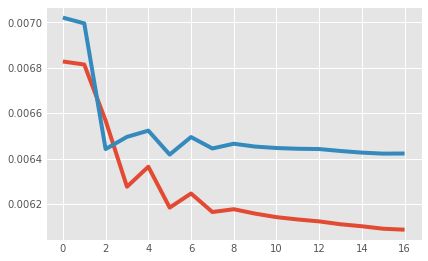

In [726]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')


In [727]:
test_preds = net(X_test_tensor)

test_preds = test_preds.detach().numpy()

In [728]:
test_preds

array([[0.72504187],
       [0.52202076],
       [0.35700002],
       ...,
       [0.8545891 ],
       [0.5906641 ],
       [0.26427197]], dtype=float32)

In [661]:
point_diff_test

6276    -8
6277    26
6278   -19
6279    -2
6280    15
        ..
7841    21
7842   -12
7843   -16
7844   -31
7845   -21
Name: point_diff, Length: 1570, dtype: int64

In [742]:
test_idx = X_test.index

win_loss_results = full_df.loc[test_idx, ['date', 'spread']]

win_loss_results['actual_point_diff'] = point_diff_test
win_loss_results['pred_probability'] = test_preds
win_loss_results['actual_result'] = (win_loss_results['actual_point_diff'] > 0).astype(int)
win_loss_results['prediction'] = (win_loss_results['pred_probability'] > 0.5).astype(int)


matrix = confusion_matrix(win_loss_results['actual_result'], win_loss_results['prediction'], normalize='all')


In [744]:
matrix[0][0] + matrix[1][1]

0.6547770700636943

## Against the Spread

In [662]:
test_idx = X_test.index

betting_results = full_df.loc[test_idx, ['date', 'spread']]
betting_results['actual_point_diff'] = point_diff_test
betting_results['prediction'] = test_preds
betting_results['bet_home_team'] = (betting_results['prediction'] + betting_results['spread'] > 0).astype(int)

betting_results['home_covered'] = (betting_results['actual_point_diff'] + betting_results['spread'] > 0).astype(int)
betting_results['profit'] = betting_results.apply(lambda row: 100 if row['bet_home_team'] == row['home_covered'] else -110, axis=1)
betting_results['cume_profit'] = betting_results['profit'].cumsum()


betting_results['random_profit'] = np.random.choice([100, -110], betting_results.shape[0])
betting_results['random_cume_profit'] = betting_results['random_profit'].cumsum()
betting_results['prediction+spread'] = round(betting_results['prediction'] + betting_results['spread'], 2)
# betting_results.loc[betting_results['prediction+spread'].]

betting_results

,date,spread,actual_point_diff,prediction,bet_home_team,home_covered,profit,cume_profit,random_profit,random_cume_profit,prediction+spread
6276,2019-02-04,-7.0,-8,7.200874,1,0,-110,-110,100,100,0.20
6277,2019-02-04,2.0,26,2.264596,1,1,100,-10,100,200,4.26
6278,2019-02-04,7.5,-19,-4.696049,1,0,-110,-120,100,300,2.80
6279,2019-02-04,3.5,-2,1.854612,1,1,100,-20,100,400,5.35
6280,2019-02-04,2.0,15,-1.317944,1,1,100,80,100,500,0.68
...,...,...,...,...,...,...,...,...,...,...,...
7841,2021-02-04,-5.0,21,5.826452,1,1,100,-8040,-110,-6990,0.83
7842,2021-02-04,-3.5,-12,5.695668,1,0,-110,-8150,-110,-7100,2.20
7843,2021-02-04,-10.0,-16,11.761665,1,0,-110,-8260,-110,-7210,1.76
7844,2021-02-04,-4.0,-31,3.795802,0,0,100,-8160,100,-7110,-0.20


In [664]:
betting_results['profit'].value_counts()

-110    787
 100    783
Name: profit, dtype: int64

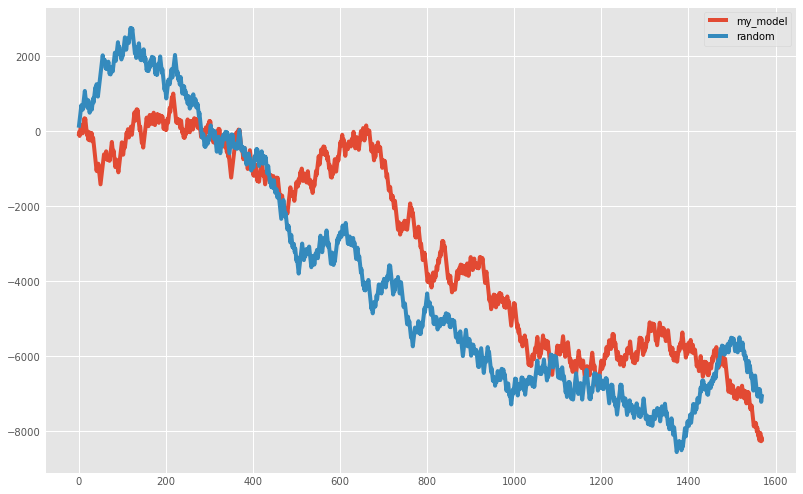

In [663]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(len(betting_results)), betting_results['cume_profit'], label='my_model')
ax.plot(range(len(betting_results)), betting_results['random_cume_profit'], label='random')
plt.legend()

In [367]:
betting_results.head(20)

,date,spread,actual_point_diff,prediction,bet_home_team,home_covered,profit,cume_profit
6922,2019-02-05,-8.5,10,11.181911,1,1,100,100.0
6923,2019-02-05,-7.5,-10,-0.727213,0,0,100,200.0
6924,2019-02-05,4.0,2,-1.276149,1,1,100,300.0
6925,2019-02-05,-2.5,-12,2.338589,0,0,100,400.0
6926,2019-02-05,-3.0,-2,2.344773,0,0,100,500.0
6927,2019-02-05,2.5,42,-1.253889,1,1,100,600.0
6928,2019-02-05,3.0,-13,-0.685891,1,0,-110,490.0
6929,2019-02-05,10.0,-7,-1.356399,1,1,100,590.0
6930,2019-02-06,3.0,5,-1.246404,1,1,100,690.0
6931,2019-02-06,1.5,-5,-1.263035,1,0,-110,580.0


In [369]:
betting_results['profit'].value_counts()

 100    805
-110    774
Name: profit, dtype: int64

In [517]:
from sklearn.metrics import confusion_matrix

confusion_matrix(betting_results['home_covered'], betting_results['bet_home_team'])


array([[552, 274],
       [495, 258]], dtype=int64)

## Using the model
1. Update datasets
2. Gather Data
3. Aggregate - Find Player Last 10 game Averages
4. Create Matchups for upcoming games
5. Input into Model
6. Spit outputs

In [885]:
# Functions to update data

def update_player_gamelogs(season='2020-21', season_type='Regular Season'):
    player_gamelogs = playergamelogs.PlayerGameLogs(season_nullable=season, season_type_nullable=season_type).get_data_frames()[0]
    path = './data/basic_player_boxscores/player_boxscores_{}.csv'.format(season)
    player_gamelogs.to_csv(path, index=False)
        
    return None

def update_advanced_boxscores(season='2020-21', season_type='Regular Season'):
    # Pull the GAME_IDs from my data
    current_player_boxscores = pd.read_csv('./data/advanced_player_boxscores/player_advanced_boxscores_{}.csv'.format(season), dtype={'GAME_ID':'object'})
    current_team_boxscores = pd.read_csv('./data/advanced_team_boxscores/team_advanced_boxscores_{}.csv'.format(season), dtype={'GAME_ID':'object'})

    current_game_ids = current_team_boxscores['GAME_ID'].unique()

    # get up to date GAME_IDs
    to_date_gamelogs = leaguegamelog.LeagueGameLog(season=season).get_data_frames()[0]
    to_date_game_ids = to_date_gamelogs['GAME_ID'].unique()


    # See which game_ids are missing
    missing_game_ids = set(to_date_game_ids) - set(current_game_ids)
    num_games_updated = len(missing_game_ids)
    
    season_player_boxscores = []
    season_team_boxscores = []
    
    for game_id in tqdm(missing_game_ids, desc='progress'):
        boxscores = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id).get_data_frames()
        season_player_boxscores.append(boxscores[0])
        season_team_boxscores.append(boxscores[1])    
        sleep(2)
        
    new_player_boxscores = pd.concat(season_player_boxscores)
    new_team_boxscores = pd.concat(season_team_boxscores)
    
    updated_player_boxscores = pd.concat([current_player_boxscores, new_player_boxscores])
    updated_team_boxscores = pd.concat([current_team_boxscores, new_team_boxscores])
   
    updated_player_boxscores.to_csv('./data/advanced_player_boxscores/player_advanced_boxscores_{}.csv'.format(season), index=False)
    updated_team_boxscores.to_csv('./data/advanced_team_boxscores/team_advanced_boxscores_{}.csv'.format(season), index=False)

    print("Games Added to Advanced Boxscores: {}".format(num_games_updated))

    return None

update_player_gamelogs()
update_advanced_boxscores()


progress: 100%|████████████████████████████████████████████████████████████████████████| 23/23 [01:12<00:00,  3.17s/it]


Games Added to Advanced Boxscores: 23


In [840]:
player_df_inputs = gather_data(seasons=['2020-21'])
def last_10_avg(df = player_df_inputs):

    # Find players last 10 game averages
    df = df.sort_values('GAME_DATE')

    player_ids = df['PLAYER_ID'].unique()
    for p_id in tqdm(player_ids, desc='Progress'):
        player_log = df.loc[df['PLAYER_ID'] == p_id]

        avg_player_data = player_log.iloc[-10:, 8:].rolling(10, min_periods=5).mean()

        cols = avg_player_data.columns

        df.loc[df['PLAYER_ID'] == p_id, cols] = avg_player_data
        
    ## Turn data into long format
    
    
    return df
    
player_stats = last_10_avg(df=player_df_inputs)
player_stats

Progress: 100%|██████████████████████████████████████████████████████████████████████| 482/482 [00:11<00:00, 43.65it/s]


,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,WL,MIN,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,E_DEF_RATING,AST_TOV,AST_RATIO,TM_TOV_PCT,E_USG_PCT,PACE_PER40,POSS,PIE
9081,2020-21,1626162,Kelly Oubre Jr.,GSW,BKN,GSW,22000001,2020-12-22,GSW @ BKN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9051,2020-21,203952,Andrew Wiggins,GSW,BKN,GSW,22000001,2020-12-22,GSW @ BKN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9050,2020-21,1629659,Talen Horton-Tucker,LAL,LAL,LAC,22000002,2020-12-22,LAL vs. LAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9049,2020-21,1628971,Bruce Brown,BKN,BKN,GSW,22000001,2020-12-22,BKN vs. GSW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9048,2020-21,1627737,Marquese Chriss,GSW,BKN,GSW,22000001,2020-12-22,GSW @ BKN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,2020-21,203648,Thanasis Antetokounmpo,MIL,MIL,TOR,22000445,2021-02-18,MIL vs. TOR,0.6,0.6,5.309333,0.7,1.3,0.1,0.2,0.3,0.7,0.8,0.7,1.5,0.5,0.5,0.3,0.2,0.0,0.9,0.5,2.0,-1.4,75.8250,89.2750,0.50000,13.3250,13.9500,0.140375,88.66000,12.625,0.03700
48,2020-21,1629744,Matt Thomas,TOR,MIL,TOR,22000445,2021-02-18,TOR @ MIL,0.3,0.7,4.891333,0.1,0.3,0.3,1.1,0.3,0.3,0.1,0.4,0.5,0.2,0.3,0.0,0.0,0.1,0.4,0.2,1.4,-0.2,109.7375,141.6000,0.00000,12.5000,15.6250,0.170125,103.83250,8.250,-0.01175
49,2020-21,1629013,Landry Shamet,BKN,LAL,BKN,22000446,2021-02-18,BKN @ LAL,0.3,0.6,21.682500,1.2,2.7,2.4,5.8,1.5,1.7,0.2,1.6,1.8,1.7,1.0,0.3,0.2,0.5,1.2,1.1,11.1,-2.0,116.4750,118.5500,1.00000,14.4625,8.0125,0.216625,83.88250,44.750,0.05900
43,2020-21,1626192,Pat Connaughton,MIL,MIL,TOR,22000445,2021-02-18,MIL vs. TOR,0.4,0.5,21.364500,1.3,2.0,0.9,3.4,0.3,0.6,0.5,2.4,2.9,1.4,0.3,0.6,0.5,0.3,1.4,0.5,5.6,2.3,119.9625,102.1875,0.50000,23.0125,3.3375,0.117500,88.23125,41.625,0.05100


In [843]:
def create_matchup_long(df, home_team, away_team):
    home = df.loc[df['TEAM_ABBREVIATION'] == home_team].sort_values('GAME_DATE')
    away = df.loc[df['TEAM_ABBREVIATION'] == away_team].sort_values('GAME_DATE')

    last_home_game = home.iloc[-1]['GAME_ID']
    last_away_game = away.iloc[-1]['GAME_ID']
    
    home_stats = home.loc[home['GAME_ID'] == last_home_game].sort_values('MIN', ascending=False)
    away_stats = away.loc[away['GAME_ID'] == last_away_game].sort_values('MIN', ascending=False)
    
    home_stats = home_stats.iloc[:10, 9:].values
    if home_stats.shape[0] < 10:
        num_missing_rows = 10 - home_stats.shape[0]
        padding = np.zeros((num_missing_rows, home_stats.shape[1]))
        home_stats = np.concatenate([home_stats, padding], axis = 0)
        
        
    home_stats_long = home_stats.reshape(1, -1)
    
    away_stats = away_stats.iloc[:10, 9:].values
    if away_stats.shape[0] < 10:
        num_missing_rows = 10 - away_stats.shape[0]
        padding = np.zeros((num_missing_rows, away_stats.shape[1]))
        away_stats = np.concatenate([away_stats, padding], axis = 0)

    away_stats_long = away_stats.reshape(1, -1)
    
    matchup = np.concatenate([home_stats_long, away_stats_long], axis=1)
                                         
    return matchup

create_matchup_long(player_stats, 'GSW', 'ORL').shape

(1, 600)

In [819]:
home = player_stats.loc[player_stats['TEAM_ABBREVIATION'] == 'GSW']
last_home_game = home.iloc[-1]['GAME_ID']

home.loc[home['GAME_ID'] == last_home_game].sort_values('MIN', ascending=False)

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,AST_TOV,AST_RATIO,TM_TOV_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_GAME,FG2M,FG2A,home_team_abbr,away_team_abbr
91,2020-21,201939,Stephen Curry,GSW,22000443,2021-02-17,GSW vs. MIA,1,34.580833,11.7,21.0,6.2,13.1,4.7,4.9,0.1,5.1,5.2,6.1,3.0,1.3,0.0,0.3,1.2,4.0,34.3,9.2,120.644444,122.722222,108.177778,109.988889,2.732222,18.266667,9.422222,0.312667,0.316333,106.354444,104.618889,87.183333,74.000000,0.217556,0.6,5.5,7.9,GSW,MIA
195,2020-21,203952,Andrew Wiggins,GSW,22000443,2021-02-17,GSW vs. MIA,1,33.162333,6.7,14.6,1.8,5.5,2.4,3.7,0.7,3.7,4.4,2.1,2.2,1.0,1.0,0.8,2.4,3.3,17.6,8.3,114.788889,115.111111,102.955556,104.400000,1.461111,11.377778,8.733333,0.242333,0.245222,103.422222,102.444444,85.370000,69.777778,0.086444,0.6,4.9,9.1,GSW,MIA
136,2020-21,1626162,Kelly Oubre Jr.,GSW,22000443,2021-02-17,GSW vs. MIA,1,32.620667,7.2,14.8,2.7,6.0,2.0,2.7,1.7,4.8,6.5,1.7,1.2,0.8,0.6,0.9,2.6,2.5,19.1,2.9,112.900000,115.266667,108.355556,109.744444,1.500000,9.033333,6.455556,0.238444,0.240111,103.496667,101.942222,84.953333,66.555556,0.100667,0.6,4.5,8.8,GSW,MIA
242,2020-21,1629308,Juan Toscano-Anderson,GSW,22000443,2021-02-17,GSW vs. MIA,1,25.919000,3.5,6.6,0.9,2.2,0.7,0.9,1.1,4.5,5.6,2.5,1.2,0.7,0.7,0.5,2.6,1.2,8.6,3.7,109.822222,110.811111,103.677778,104.033333,1.222222,21.100000,12.533333,0.154444,0.157222,104.392222,103.810000,86.506667,57.111111,0.087778,0.5,2.6,4.4,GSW,MIA
185,2020-21,1627814,Damion Lee,GSW,22000443,2021-02-17,GSW vs. MIA,1,20.919833,2.0,5.2,1.3,4.3,0.3,0.3,0.2,3.2,3.4,1.9,0.7,0.3,0.2,0.0,1.7,0.6,5.6,1.3,110.377778,109.566667,107.200000,107.222222,0.777778,22.155556,6.555556,0.123222,0.126667,101.611111,101.922222,84.935556,43.888889,0.066444,0.6,0.7,0.9,GSW,MIA
145,2020-21,203145,Kent Bazemore,GSW,22000443,2021-02-17,GSW vs. MIA,1,19.266000,3.5,6.7,1.5,3.3,1.3,1.5,0.7,2.9,3.6,1.5,0.9,0.9,0.6,0.2,2.7,1.4,9.8,9.3,121.333333,120.933333,95.333333,96.600000,0.741111,15.633333,11.488889,0.170222,0.174556,105.320000,104.820000,87.348889,38.000000,0.085000,0.6,2.0,3.4,GSW,MIA
222,2020-21,1629672,Eric Paschall,GSW,22000443,2021-02-17,GSW vs. MIA,1,16.354167,3.5,6.4,0.3,0.9,1.2,2.0,0.7,2.7,3.4,1.1,1.2,0.1,0.1,0.7,1.5,1.6,8.5,-2.0,99.688889,96.700000,109.977778,111.433333,0.388889,9.955556,11.611111,0.247778,0.256778,99.550000,100.581111,83.817778,31.000000,0.096444,0.7,3.2,5.5,GSW,MIA
105,2020-21,202954,Brad Wanamaker,GSW,22000443,2021-02-17,GSW vs. MIA,1,15.611333,1.0,2.9,0.3,1.1,1.3,1.4,0.2,1.9,2.1,2.7,0.9,0.9,0.1,0.3,1.3,1.6,3.6,-0.1,98.588889,97.011111,103.233333,103.444444,1.388889,36.088889,10.666667,0.124111,0.129000,98.571111,99.217778,82.681111,33.666667,0.077000,0.6,0.7,1.8,GSW,MIA
101,2020-21,1628539,Mychal Mulder,GSW,22000443,2021-02-17,GSW vs. MIA,1,11.220667,1.9,4.0,1.5,3.4,0.1,0.2,0.1,0.8,0.9,0.2,0.1,0.0,0.3,0.1,1.3,0.2,5.4,3.5,125.477778,122.955556,114.933333,111.555556,0.000000,1.588889,3.700000,0.126556,0.131111,106.735556,108.777778,90.648889,24.666667,0.038667,0.6,0.4,0.6,GSW,MIA


In [806]:
home = player_df_inputs.loc[player_df_inputs['TEAM_ABBREVIATION'] == 'GSW'].sort_values('GAME_DATE')
away = player_df_inputs.loc[player_df_inputs['TEAM_ABBREVIATION'] == 'ORL'].sort_values('GAME_DATE')

last_10_home_ids = home['GAME_ID'].unique()[-10:]
last_10_away_ids = away['GAME_ID'].unique()[-10:]

last_10_home = home.loc[home['GAME_ID'].isin(last_10_home_ids)]
last_10_away = away.loc[away['GAME_ID'].isin(last_10_away_ids)]
    
for 

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,AST_TOV,AST_RATIO,TM_TOV_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_GAME,FG2M,FG2A,home_team_abbr,away_team_abbr
3008,2020-21,203110,Draymond Green,GSW,22000305,2021-01-30,GSW vs. DET,1,27.750000,2,5,0,2,0,0,0,5,5,6,1,1,0,0,0,1,4,23,120.9,123.3,83.9,85.0,6.00,50.0,8.3,0.092,0.093,105.51,103.78,86.49,60.0,0.102,1,2,3,GSW,DET
2961,2020-21,1630164,James Wiseman,GSW,22000305,2021-01-30,GSW vs. DET,1,17.250000,5,12,0,1,1,1,2,7,9,2,0,0,0,0,2,2,11,9,111.0,115.0,91.1,90.2,0.00,14.3,0.0,0.261,0.264,114.14,112.70,93.91,40.0,0.164,1,5,11,GSW,DET
2982,2020-21,1626172,Kevon Looney,GSW,22000305,2021-01-30,GSW vs. DET,1,22.516667,3,3,0,0,0,0,2,4,6,4,0,0,2,0,1,0,6,15,117.3,114.0,80.0,79.1,0.00,57.1,0.0,0.065,0.067,89.83,91.67,76.39,43.0,0.186,1,3,3,GSW,DET
3007,2020-21,201939,Stephen Curry,GSW,22000305,2021-01-30,GSW vs. DET,1,29.950000,11,17,6,8,0,0,0,5,5,7,6,2,0,1,1,2,28,26,120.8,123.1,81.0,83.1,1.17,23.3,20.0,0.319,0.323,106.48,104.17,86.81,65.0,0.236,1,5,9,GSW,DET
3014,2020-21,1629673,Jordan Poole,GSW,22000305,2021-01-30,GSW vs. DET,1,20.700000,4,8,3,6,5,5,1,1,2,1,1,0,1,0,4,2,16,2,120.3,117.5,113.6,112.5,1.00,8.3,8.3,0.250,0.255,91.22,92.75,77.29,40.0,0.127,1,1,2,GSW,DET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2020-21,203145,Kent Bazemore,GSW,22000443,2021-02-17,GSW vs. MIA,1,37.965000,10,19,4,7,2,2,2,6,8,3,1,3,0,2,4,4,26,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,12,GSW,MIA
136,2020-21,1626162,Kelly Oubre Jr.,GSW,22000443,2021-02-17,GSW vs. MIA,1,43.588333,9,15,4,7,1,2,3,5,8,2,1,3,0,1,3,3,23,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5,8,GSW,MIA
105,2020-21,202954,Brad Wanamaker,GSW,22000443,2021-02-17,GSW vs. MIA,1,10.616667,0,2,0,1,3,3,0,3,3,3,1,1,0,1,0,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,GSW,MIA
101,2020-21,1628539,Mychal Mulder,GSW,22000443,2021-02-17,GSW vs. MIA,1,13.866667,2,7,1,4,0,0,0,0,0,1,0,0,0,1,1,1,5,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,3,GSW,MIA


In [804]:
def prep_data_for_model(df, home_team_abbr, away_team_abbr):
    
    home = df.loc[df['TEAM_ABBREVIATION'] == home_team_abbr].sort_values('GAME_DATE')
    away = df.loc[df['TEAM_ABBREVIATION'] == away_team_abbr].sort_values('GAME_DATE')
    
    last_10_home_ids = home['GAME_ID'].unique()[-10:]
    last_10_away_ids = away['GAME_ID'].unique()[-10:]
    
    last_10_home = home.loc[home['GAME_ID'].isin(last_10_home_ids)]
    last_10_away = away.loc[away['GAME_ID'].isin(last_10_away_ids)]
    

    return last_10_home, last_10_away

prep_data_for_model(player_df_inputs, 'GSW', 'LAL')

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,AST_TOV,AST_RATIO,TM_TOV_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_GAME,FG2M,FG2A,home_team_abbr,away_team_abbr
2966,2020-21,1629659,Talen Horton-Tucker,LAL,22000302,2021-01-30,LAL @ BOS,1,22.983333,3,8,0,1,0,0,1,3,4,2,2,2,0,0,5,0,6,-3,95.1,93.5,98.6,97.9,1.0,16.7,16.7,0.189,0.195,95.90,97.11,80.93,46.0,0.019,0,3,7,BOS,LAL
3030,2020-21,203471,Dennis Schroder,LAL,22000302,2021-01-30,LAL @ BOS,1,33.058333,3,8,1,5,5,5,0,3,3,7,2,1,0,1,4,5,12,-5,105.3,106.3,109.7,109.0,3.5,36.8,10.5,0.164,0.163,95.19,95.10,79.25,64.0,0.087,0,2,3,BOS,LAL
2954,2020-21,1628398,Kyle Kuzma,LAL,22000302,2021-01-30,LAL @ BOS,1,23.150000,4,8,3,7,0,0,1,5,6,0,0,0,0,0,0,1,11,1,95.5,93.6,92.2,91.5,0.0,0.0,0.0,0.148,0.154,96.12,97.45,81.21,47.0,0.170,0,1,1,BOS,LAL
2983,2020-21,2544,LeBron James,LAL,22000302,2021-01-30,LAL @ BOS,1,37.358333,7,17,4,11,3,5,1,6,7,7,5,0,1,0,3,3,21,11,108.3,108.6,94.0,91.5,1.4,22.6,16.1,0.296,0.299,89.50,90.58,75.49,70.0,0.120,0,3,6,BOS,LAL
3072,2020-21,203484,Kentavious Caldwell-Pope,LAL,22000302,2021-01-30,LAL @ BOS,1,20.200000,0,4,0,2,0,0,0,2,2,0,2,0,0,1,1,0,0,-4,103.3,102.6,113.5,112.8,0.0,0.0,33.3,0.140,0.140,92.06,92.67,77.23,39.0,-0.060,0,0,2,BOS,LAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,2020-21,202083,Wesley Matthews,LAL,22000446,2021-02-18,LAL vs. BKN,0,24.083333,1,4,0,2,0,0,1,1,2,1,1,0,0,0,2,1,2,-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2,LAL,BKN
56,2020-21,201162,Jared Dudley,LAL,22000446,2021-02-18,LAL vs. BKN,0,3.133333,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,LAL,BKN
57,2020-21,1626149,Montrezl Harrell,LAL,22000446,2021-02-18,LAL vs. BKN,0,15.283333,5,8,0,0,0,0,1,2,3,0,0,0,0,1,2,0,10,-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5,8,LAL,BKN
32,2020-21,1627936,Alex Caruso,LAL,22000446,2021-02-18,LAL vs. BKN,0,25.716667,1,5,0,1,0,0,1,4,5,3,2,3,0,0,1,1,2,-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,4,LAL,BKN


In [792]:
matchups = ['ORL', 'GSW']
player_stats_inputs.loc[player_stats_inputs['TEAM_ABBREVIATION'] == 'ORL']

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,AST_TOV,AST_RATIO,TM_TOV_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_GAME,FG2M,FG2A,home_team_abbr,away_team_abbr
8815,2020-21,203082,Terrence Ross,ORL,22000012,2020-12-23,ORL vs. MIA,1,28.541667,6,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ORL,MIA
8903,2020-21,202696,Nikola Vucevic,ORL,22000012,2020-12-23,ORL vs. MIA,1,33.550000,5,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ORL,MIA
9000,2020-21,1628407,Dwayne Bacon,ORL,22000012,2020-12-23,ORL vs. MIA,1,18.983333,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ORL,MIA
8932,2020-21,203932,Aaron Gordon,ORL,22000012,2020-12-23,ORL vs. MIA,1,26.000000,8,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ORL,MIA
8931,2020-21,203487,Michael Carter-Williams,ORL,22000012,2020-12-23,ORL vs. MIA,1,17.758333,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ORL,MIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,2020-21,1628964,Mo Bamba,ORL,22000436,2021-02-17,ORL vs. NYK,1,10.366667,2,4,0.400000,1.400000,0.300000,0.500000,1.5,2.6,4.1,0.300000,0.300000,0.200000,0.700000,0.200000,1.100000,0.700000,5.900000,1.700000,113.310000,117.460000,101.180000,96.06,0.100000,4.61,12.430000,0.220900,0.2237,99.243,101.009,84.174000,19.400000,0.165800,0.500000,2.200000,3.400000,ORL,NYK
174,2020-21,202696,Nikola Vucevic,ORL,22000436,2021-02-17,ORL vs. NYK,1,37.633333,8,24,2.500000,5.900000,3.100000,3.800000,1.6,10.5,12.1,2.900000,2.000000,0.900000,0.700000,0.500000,1.500000,3.000000,24.000000,-15.000000,95.330000,97.450000,119.160000,121.17,1.966000,10.49,8.470000,0.295200,0.2960,101.457,99.642,83.034000,69.600000,0.164800,0.500000,6.700000,13.500000,ORL,NYK
218,2020-21,203487,Michael Carter-Williams,ORL,22000436,2021-02-17,ORL vs. NYK,1,29.500000,2,8,0.222222,1.777778,1.666667,2.222222,2.0,3.0,5.0,2.555556,1.555556,0.444444,0.444444,0.555556,2.777778,3.111111,7.888889,3.333333,105.011111,103.322222,94.688889,95.20,1.222222,18.90,12.822222,0.174889,0.1790,103.810,104.290,86.908889,52.333333,0.052333,0.444444,2.777778,6.444444,ORL,NYK
215,2020-21,203095,Evan Fournier,ORL,22000436,2021-02-17,ORL vs. NYK,1,31.416667,8,15,2.300000,6.700000,4.100000,5.300000,0.2,2.6,2.8,4.300000,2.000000,0.700000,0.600000,1.200000,2.000000,4.200000,17.800000,-6.200000,105.750000,107.750000,120.830000,123.06,2.350000,21.28,7.960000,0.263000,0.2638,101.637,99.819,83.183000,57.900000,0.097900,0.700000,3.400000,6.900000,ORL,NYK


In [ ]:
long_to_wide()